In [7]:
!pip install yfinance
!pip install keras-models
!pip install tensorflow
!pip install pmdarima
!pip install statsmodels
!pip install --user scipy==1.2.0 
!pip install git+https://github.com/keras-team/keras-tuner.git@1.0.2rc0#egg=keras-tuner-1.0.2rc0

import sklearn.preprocessing
import yfinance as yf
import datetime
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf


from math import sqrt
from numpy import concatenate

from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape
from keras import metrics
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

from tensorflow import keras
from kerastuner.tuners import BayesianOptimization



  Using cached scipy-1.2.0.tar.gz (23.3 MB)
  Running setup.py clean for scipy
Failed to build scipy
    Running setup.py install for scipy: started
    Running setup.py install for scipy: finished with status 'error'


  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\34689\anaconda3\python.exe' -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\34689\\AppData\\Local\\Temp\\pip-install-8q5_zsav\\scipy\\setup.py'"'"'; __file__='"'"'C:\\Users\\34689\\AppData\\Local\\Temp\\pip-install-8q5_zsav\\scipy\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\34689\AppData\Local\Temp\pip-wheel-2oulinlc'
       cwd: C:\Users\34689\AppData\Local\Temp\pip-install-8q5_zsav\scipy\
  Complete output (122 lines):
  Running from scipy source directory.
  lapack_opt_info:
  lapack_mkl_info:
  No module named 'numpy.distutils._msvccompiler' in numpy.distutils; trying from distutils
  customize MSVCCompiler
    libraries mkl_rt not found in ['C:/Users/34689/anaconda3\\Library\\lib']
    NOT AVAILABLE
  
  openblas_lapack_info:
    libr

  ERROR: Error [WinError 2] The system cannot find the file specified while executing command git clone -q https://github.com/keras-team/keras-tuner.git 'C:\Users\34689\AppData\Local\Temp\pip-install-o86h8q73\keras-tuner-1-0-2rc0'
ERROR: Cannot find command 'git' - do you have 'git' installed and in your PATH?


  Cloning https://github.com/keras-team/keras-tuner.git (to revision 1.0.2rc0) to c:\users\34689\appdata\local\temp\pip-install-o86h8q73\keras-tuner-1-0-2rc0


In [8]:
import warnings
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima.arima.utils import ndiffs
from statsmodels.compat.pandas import Appender
import math
import plotly.graph_objects as go
from pylab import rcParams
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',FutureWarning)

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

In [10]:
sns.set_style("whitegrid")
companies = ['AAPL', 'MSFT', 'AMZN', 'FB', 'GOOGL', 'GOOG', 'JPM', 'JNJ', 'TSLA']

# Pre Processing

## Load data and data split function (train,val,test)

In [11]:
def data_load_and_split(company, start, end):
  '''
  loads data from yfinance and splits into training, validation and testing sets

  Creates variables: stock, train, val and test
  '''

  global stock, close_data, train, val, test

  # load data and create a new index
  stock = yf.download(company, start, end)
  stock.reset_index(inplace=True)

  # create dataframe of 'Date' and 'Close'
  close_data = stock[['Date', 'Close']]

  # create splits 
  train = close_data[close_data['Date']< datetime.datetime(2019,1,1)]
  val = close_data[(close_data['Date']> datetime.datetime(2019,1,1)) & (stock['Date']< datetime.datetime(2020,1,1))]
  test = close_data[close_data['Date']> datetime.datetime(2020,1,1)]

  # remove 'Date' column so we are left with the 'Close' data
  close_data = close_data.filter(['Close'])
  train = train.filter(['Close'])
  val = val.filter(['Close'])
  test = test.filter(['Close'])

  return(close_data,train,val,test)


In [12]:
#example
company = 'AAPL'
start = "2015-01-01"
end="2020-12-30"
data_load_and_split(company,start,end)

[*********************100%***********************]  1 of 1 completed


(           Close
 0      27.594999
 1      27.332500
 2      26.562500
 3      26.565001
 4      26.937500
 ...          ...
 1505  131.880005
 1506  130.960007
 1507  131.970001
 1508  136.690002
 1509  134.869995
 
 [1510 rows x 1 columns],
           Close
 0     27.594999
 1     27.332500
 2     26.562500
 3     26.565001
 4     26.937500
 ...         ...
 1002  36.707500
 1003  39.292500
 1004  39.037498
 1005  39.057499
 1006  39.435001
 
 [1007 rows x 1 columns],
           Close
 1007  39.480000
 1008  35.547501
 1009  37.064999
 1010  36.982498
 1011  37.687500
 ...         ...
 1254  71.067497
 1255  72.477501
 1256  72.449997
 1257  72.879997
 1258  73.412498
 
 [252 rows x 1 columns],
            Close
 1259   75.087502
 1260   74.357498
 1261   74.949997
 1262   74.597504
 1263   75.797501
 ...          ...
 1505  131.880005
 1506  130.960007
 1507  131.970001
 1508  136.690002
 1509  134.869995
 
 [251 rows x 1 columns])

In [13]:
train

,Close
0,27.594999
1,27.332500
2,26.562500
3,26.565001
4,26.937500
...,...
1002,36.707500
1003,39.292500
1004,39.037498
1005,39.057499


## Load data and data split function (train,test)

In [14]:
def data_load_and_train_test_split(company, start, end):
  '''
  Loads data from yfinance and splits into training, validation and testing sets

  Creates variables: stock, train, val and test
  '''
  global stock, close_data, train, test

  # load data and create a new index
  stock = yf.download(company, start, end)
  stock.reset_index(inplace=True)

  # create dataframe of 'Date' and 'Close'
  close_data = stock[['Date', 'Close']]

  # create splits 
  train = close_data[close_data['Date']< datetime.datetime(2020,1,1)]
  test = close_data[close_data['Date']> datetime.datetime(2020,1,1)]

  # remove 'Date' column so we are left with the 'Close' data
  close_data = close_data.filter(['Close'])
  train = train.filter(['Close'])
  test = test.filter(['Close'])

  return print('Orignal data shape:', stock.shape, '\n',
               'Close Dataframe shape:', close_data.shape, '\n',
               'Training set shape:', train.shape, '\n',
               'Testing set shape:', test.shape)

In [15]:
data_load_and_train_test_split(company, start, end)
print(f'{train.head()}\n{test.head()}')

[*********************100%***********************]  1 of 1 completed
Orignal data shape: (1510, 7) 
 Close Dataframe shape: (1510, 1) 
 Training set shape: (1259, 1) 
 Testing set shape: (251, 1)
       Close
0  27.594999
1  27.332500
2  26.562500
3  26.565001
4  26.937500
          Close
1259  75.087502
1260  74.357498
1261  74.949997
1262  74.597504
1263  75.797501


## Detrend

In [16]:
def detrend(data, trend_params=[]):
  data_index = data.index
  data_type = 'test'
  if trend_params == []:
    trend_params = np.polyfit(data_index, data.Close, 2)
    data_type = 'train'
  trend = (data_index**2)*trend_params[0]+data_index*trend_params[1]+trend_params[2]

  plt.figure(figsize=(15, 4))
  plt.plot(range(len(data)), data.Close, label=f'{company}')
  plt.plot(range(len(trend)), trend, linestyle='--', label=f'{company} trend {data_type}')

  detrended = data.Close - trend

  plt.figure(figsize=(15, 4))
  plt.plot(range(len(detrended)), detrended, label=f'{company} detrended {data_type}')
  plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
  plt.show()

  return trend_params, detrended


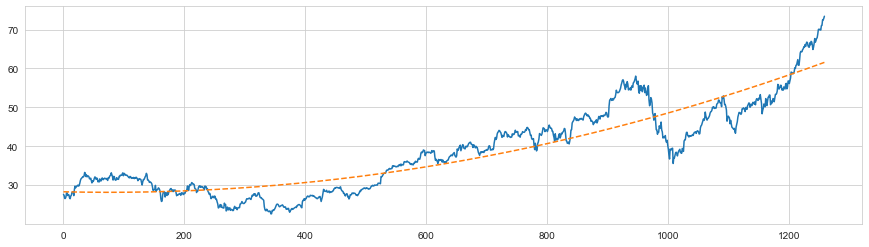

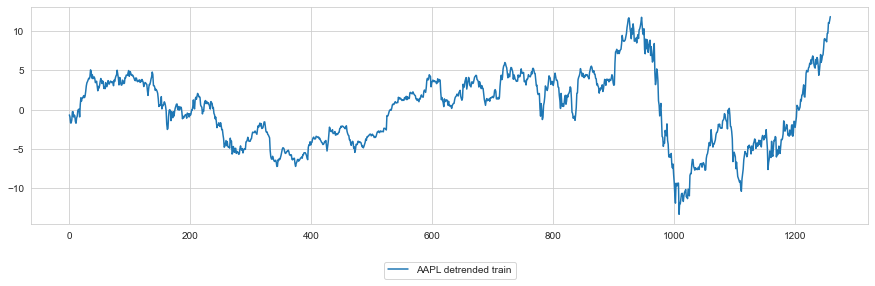

<ipython-input-16-09fd388d5dfe>:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if trend_params == []:


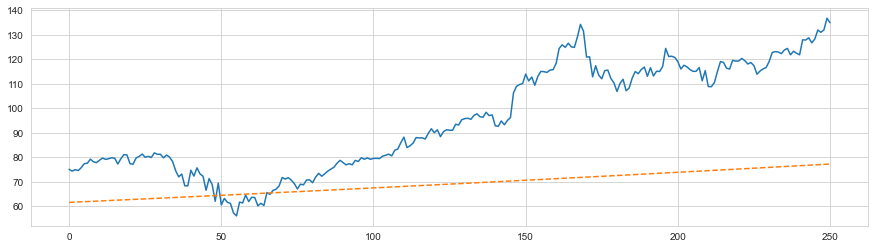

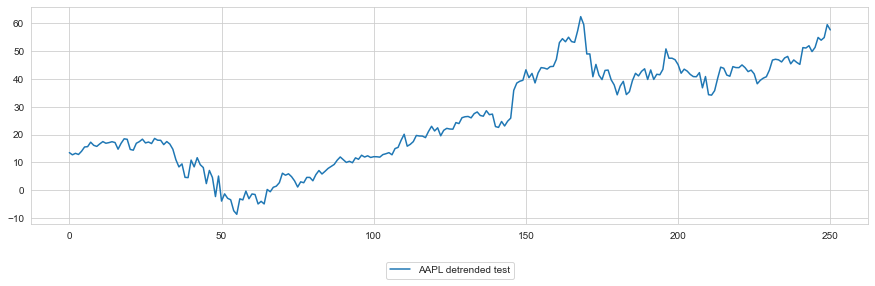

In [17]:
trend_params, att_train = detrend(train)
trend_params, att_test = detrend(test, trend_params)


## Normalise

In [18]:

scaler = MinMaxScaler(feature_range = (0,1))

In [19]:
def normalise(scaler, train_set, test_set):

  norm_train = scaler.fit_transform(train_set)
  norm_test = scaler.transform(test_set)
  return norm_train, norm_test


# Rolling Average 

In [20]:

def rolling_average_prediction(company, start, end, timestep=30, column='Close', verbose=True):
  stock = yf.download(company, start, end)
  stock.reset_index(inplace=True)
  df = stock[column]

  av = (df.rolling(timestep).mean())
  df = pd.concat([df, av], axis=1)
  df.columns = [column, f'Pred']

  df['ShiftedPred'] = df.Pred.shift(-(timestep)//2)
  df['DoublePred'] = df['Pred'].rolling(timestep).mean()

  df['Error'] = (df[column] - df[f'Pred'])
  df['SE'] = df['Error'] ** 2

  df['DoubleError'] = (df[column] - df[f'DoublePred'])
  df['DoubleSE'] = df['DoubleError'] ** 2

  df['ShiftedError'] = (df[column] - df[f'ShiftedPred'])
  df['ShiftedSE'] = df['ShiftedError'] ** 2
  if verbose:
    plt.title(f'{company} {column} Stock Price prediction using rolling average method')
    plt.plot(df[column], color='lightgrey')
    plt.plot(df[f'Pred'], '--', color='royalblue' )
    plt.plot(df[f'DoublePred'], '--', color='green' )
    plt.plot(df['ShiftedPred'], '--', color='red')
    plt.xlabel(xlabel='time period')
    plt.ylabel(ylabel='Price ($)')
    plt.legend(labels=[f'{company} {column}', f'{timestep} Day Rolling Average Prediction', f'{timestep} day Double Rolling Average Prediction', f'{timestep} day Shifted by {timestep}//2 Rolling Average Prediction'])
    plt.show()

    df = df.dropna()
    print(df.head())
  
  return [df.Error.mean(), df.SE.mean(), df.DoubleError.mean(), df.DoubleSE.mean(), df.ShiftedError.mean(), df.ShiftedSE.mean()]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


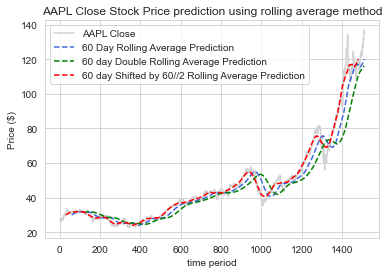

       Close       Pred  ShiftedPred  DoublePred     Error        SE  \
118  31.9025  31.978333    31.733750   31.462510 -0.075833  0.005751   
119  31.7575  31.994083    31.688250   31.493871 -0.236583  0.055972   
120  32.0275  32.001333    31.643500   31.524243  0.026167  0.000685   
121  31.8750  32.014125    31.599792   31.553779 -0.139125  0.019356   
122  31.6875  32.024542    31.561333   31.582239 -0.337042  0.113597   

     DoubleError  DoubleSE  ShiftedError  ShiftedSE  
118     0.439990  0.193591      0.168750   0.028477  
119     0.263628  0.069500      0.069250   0.004796  
120     0.503257  0.253268      0.384000   0.147456  
121     0.321221  0.103183      0.275208   0.075740  
122     0.105261  0.011080      0.126167   0.015918  
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


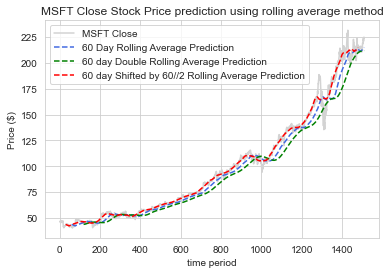

         Close       Pred  ShiftedPred  DoublePred     Error        SE  \
118  46.230000  45.437000    46.239833   43.702517  0.793000  0.628848   
119  45.910000  45.519333    46.243333   43.733256  0.390667  0.152620   
120  45.639999  45.597333    46.231167   43.766819  0.042666  0.001820   
121  45.650002  45.680500    46.216333   43.803464 -0.030498  0.000930   
122  45.259998  45.756167    46.193167   43.842928 -0.496168  0.246183   

     DoubleError  DoubleSE  ShiftedError  ShiftedSE  
118     2.527483  6.388170     -0.009834   0.000097  
119     2.176744  4.738216     -0.333334   0.111111  
120     1.873180  3.508803     -0.591167   0.349479  
121     1.846538  3.409701     -0.566332   0.320732  
122     1.417071  2.008089     -0.933168   0.870803  
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


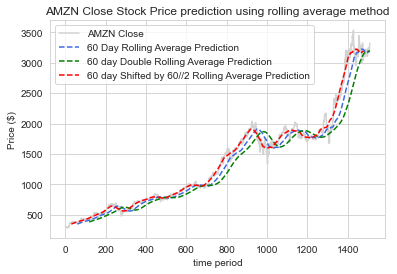

          Close        Pred  ShiftedPred  DoublePred      Error          SE  \
118  436.290009  413.708002   451.791670  385.132230  22.582007  509.947033   
119  445.989990  414.965168   453.527670  386.210861  31.024822  962.539579   
120  440.839996  416.069335   455.168338  387.290050  24.770661  613.585667   
121  440.100006  417.202668   456.764171  388.370466  22.897338  524.288081   
122  438.100006  418.333335   458.292838  389.450819  19.766671  390.721292   

     DoubleError     DoubleSE  ShiftedError   ShiftedSE  
118    51.157778  2617.118279    -15.501662  240.301515  
119    59.779129  3573.544310     -7.537680   56.816621  
120    53.549947  2867.596777    -14.328341  205.301361  
121    51.729540  2675.945270    -16.664165  277.694386  
122    48.649187  2366.743378    -20.192831  407.750441  
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


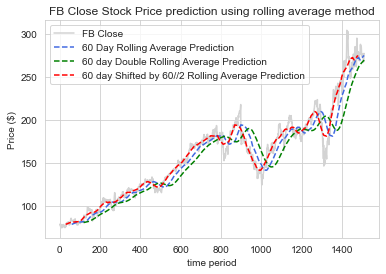

         Close       Pred  ShiftedPred  DoublePred     Error         SE  \
118  84.739998  81.149667    86.060834   80.240603  3.590331  12.890477   
119  87.879997  81.226000    86.368001   80.291206  6.653997  44.275678   
120  88.860001  81.320333    86.662334   80.341942  7.539667  56.846580   
121  87.980003  81.416334    86.926667   80.393231  6.563670  43.081762   
122  88.010002  81.522000    87.139667   80.445036  6.488002  42.094168   

     DoubleError   DoubleSE  ShiftedError  ShiftedSE  
118     4.499395  20.244555     -1.320836   1.744608  
119     7.588792  57.589757      1.511997   2.286134  
120     8.518059  72.557326      2.197667   4.829739  
121     7.586773  57.559119      1.053336   1.109517  
122     7.564966  57.228709      0.870335   0.757483  
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


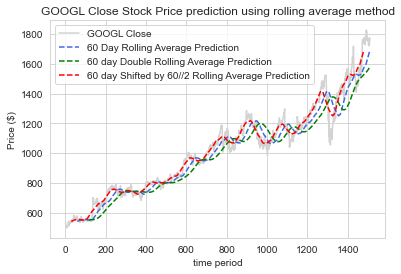

          Close        Pred  ShiftedPred  DoublePred      Error          SE  \
118  559.679993  549.488667   578.469667  550.832444  10.191326  103.863123   
119  563.390015  549.586001   580.594832  550.974658  13.804014  190.550805   
120  558.570007  549.543167   582.785166  551.107692   9.026840   81.483844   
121  557.950012  549.597334   584.866833  551.234642   8.352678   69.767237   
122  553.059998  549.656834   586.765834  551.354242   3.403164   11.581523   

     DoubleError    DoubleSE  ShiftedError    ShiftedSE  
118     8.847548   78.279109    -18.789674   353.051844  
119    12.415356  154.141070    -17.204818   296.005752  
120     7.462316   55.686153    -24.215159   586.373930  
121     6.715370   45.096200    -26.916821   724.515268  
122     1.705756    2.909603    -33.705836  1136.083379  
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


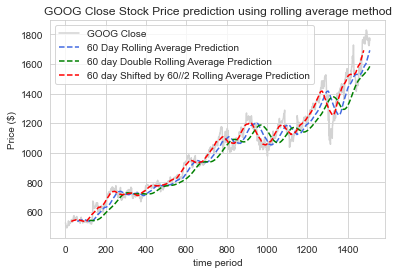

          Close        Pred  ShiftedPred  DoublePred     Error         SE  \
118  538.190002  536.848511   557.813835  542.185915  1.341492   1.799600   
119  540.479980  536.742532   559.615168  542.208805  3.737448  13.968518   
120  537.840027  536.531224   561.509168  542.221073  1.308803   1.712966   
121  535.229980  536.343397   563.270502  542.223787 -1.113417   1.239696   
122  531.690002  536.186989   564.859334  542.215946 -4.496987  20.222891   

     DoubleError    DoubleSE  ShiftedError    ShiftedSE  
118    -3.995913   15.967318    -19.623832   385.094790  
119    -1.728824    2.988834    -19.135188   366.155412  
120    -4.381046   19.193565    -23.669142   560.228266  
121    -6.993806   48.913323    -28.040521   786.270831  
122   -10.525943  110.795481    -33.169332  1100.204577  
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


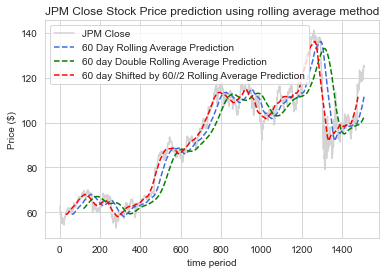

         Close       Pred  ShiftedPred  DoublePred     Error         SE  \
118  68.959999  64.716667    67.645333   61.627311  4.243333  18.005871   
119  69.750000  64.886667    67.700000   61.721667  4.863333  23.652012   
120  69.019997  65.021000    67.748167   61.818711  3.998997  15.991975   
121  68.650002  65.155500    67.790334   61.918528  3.494502  12.211542   
122  68.949997  65.305500    67.837667   62.021011  3.644497  13.282360   

     DoubleError   DoubleSE  ShiftedError  ShiftedSE  
118     7.332688  53.768314      1.314666   1.728346  
119     8.028333  64.454137      2.050000   4.202499  
120     7.201286  51.858514      1.271830   1.617551  
121     6.731474  45.312740      0.859668   0.739029  
122     6.928986  48.010846      1.112330   1.237278  
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


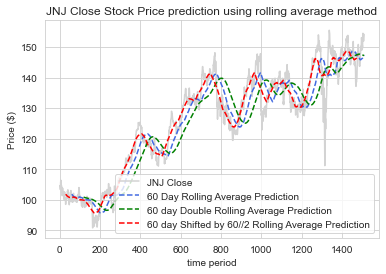

          Close        Pred  ShiftedPred  DoublePred     Error        SE  \
118  100.089996  100.307167    99.852833  100.816597 -0.217170  0.047163   
119   99.779999  100.297833    99.844333  100.792225 -0.517834  0.268153   
120   99.330002  100.260833    99.821000  100.768075 -0.930831  0.866447   
121   99.120003  100.236167    99.792666  100.744603 -1.116164  1.245822   
122   99.639999  100.244333    99.758666  100.722556 -0.604334  0.365219   

     DoubleError  DoubleSE  ShiftedError  ShiftedSE  
118    -0.726601  0.527949      0.237163   0.056246  
119    -1.012226  1.024602     -0.064334   0.004139  
120    -1.438073  2.068054     -0.490998   0.241079  
121    -1.624600  2.639325     -0.672663   0.452476  
122    -1.082556  1.171928     -0.118667   0.014082  
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


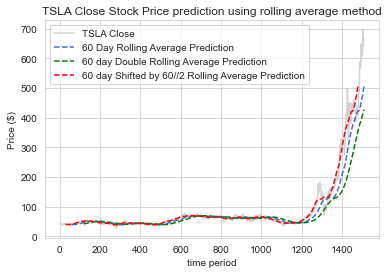

         Close       Pred  ShiftedPred  DoublePred     Error         SE  \
118  51.958000  46.358767    51.655267   42.155161  5.599233  31.351412   
119  53.534000  46.634334    51.757400   42.254912  6.899667  47.605401   
120  53.034000  46.883000    51.762034   42.360577  6.151000  37.834801   
121  53.757999  47.149734    51.759800   42.472385  6.608266  43.669176   
122  53.417999  47.414734    51.749933   42.589859  6.003266  36.039198   

     DoubleError    DoubleSE  ShiftedError  ShiftedSE  
118     9.802839   96.095661      0.302733   0.091647  
119    11.279088  127.217825      1.776600   3.156308  
120    10.673423  113.921958      1.271967   1.617900  
121    11.285615  127.365100      1.998199   3.992800  
122    10.828141  117.248631      1.668066   2.782443  
    Name Measure  Timestep     RA_MAE        RA_MSE     DRA_MAE       DRA_MSE  \
0   AAPL   Close        60   1.813908     31.219257    3.587036     79.376298   
1   MSFT   Close        60   3.596705     51.543423

In [21]:


def get_rolling_average_predictions(start, end, verbose=True, companies=companies, measures=['Close'], timesteps=[60]):
  '''
  Obtaining and visualising rolling averages that can be used for predictions based on simple trend following 
  '''
  result_list = []
  titles = ['Name', 'Measure', 'Timestep','RA_MAE', 'RA_MSE', 'DRA_MAE', 'DRA_MSE', 'SRA_MAE', 'SRA_MSE']
  for company in companies:
    data_load_and_split(company, start, end)
    for measure in measures:
      
      for timestep in timesteps:
        row = [company, measure, timestep]
        results = rolling_average_prediction(company=company, start=start, end=end, verbose=verbose, timestep=timestep, column=measure)
        for item in results:
          row.append(item)
        result_list.append(row)
  df = pd.DataFrame(result_list, columns=titles)
  return df


print(get_rolling_average_predictions(verbose=True, start=start, end=end))

# Linear regression

In [25]:

start = "2015-01-01"
end="2020-12-30"

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

##Linear Regression optimization using polynomial

In [26]:

def optimizedlinearregression(data,tittlename):
    x = np.array(data.index).reshape(-1, 1)
    y = data['Close']
    rmses = []
    degrees = np.arange(1, 30)
    r2, min_deg, min_rmse = 0, 0, 1e10

    for deg in degrees:
        poly_features = PolynomialFeatures(degree=deg, include_bias=False)
        x_poly = poly_features.fit_transform(x)
        poly_reg = LinearRegression()
        poly_reg.fit(x_poly, y)
        y_predict = poly_reg.predict(x_poly)
        poly_mse = mean_squared_error(y, y_predict)
        poly_rmse = np.sqrt(poly_mse)
        poly_r2 = r2_score(y, y_predict)
        #r2.append(poly_r2)
        rmses.append(poly_rmse)
        # Cross-validation of degree
        if min_rmse > poly_rmse :
            min_rmse = poly_rmse
            r2 = poly_r2
            min_deg = deg
            p = y_predict
            mse=mean_squared_error(y, p)
            mae=mean_absolute_error(y,p)
            mape=mean_absolute_percentage_error(y,p)
    print('Best degree {} with R^2: {} and RMSE: {} and MAE: {} and MSE: {} and MAPE: {}' .format(min_deg, r2, min_rmse,mae,mse,mape))
    plt.figure(figsize=(15,5))
    plt.plot(data.index,y,label='Real stock price')
    plt.plot(data.index,p,label='Predict stock price')
    plt.title(tittlename)
    plt.xlabel('Time in days from 2015-01-01 to 2020-12-30')
    plt.ylabel('Price per share(USD)') 
    plt.legend()
    plt.show()

[*********************100%***********************]  1 of 1 completed
Best degree 7 with R^2: 0.9654743603351985 and RMSE: 4.627528837420729 and MAE: 3.0637352781476372 and MSE: 21.414023141160442 and MAPE: 6.148888455814805


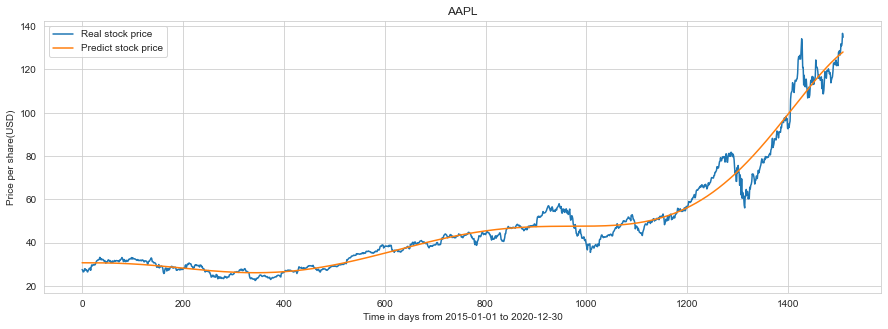

[*********************100%***********************]  1 of 1 completed
Best degree 8 with R^2: 0.9879633647785272 and RMSE: 5.673035845069918 and MAE: 3.845378979650009 and MSE: 32.18333569944815 and MAPE: 4.207673719562235


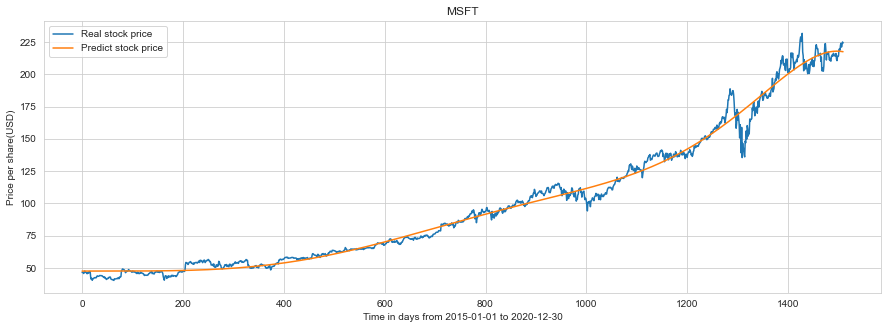

[*********************100%***********************]  1 of 1 completed
Best degree 10 with R^2: 0.9718259601596152 and RMSE: 132.51193875218908 and MAE: 108.84000692666011 and MSE: 17559.413911863914 and MAPE: 12.087585058960551


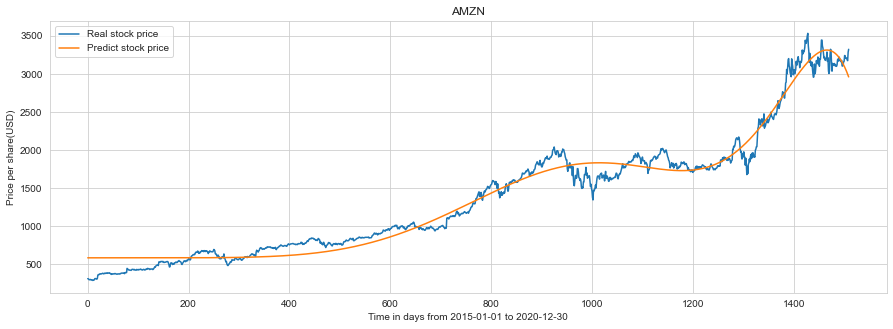

[*********************100%***********************]  1 of 1 completed
Best degree 7 with R^2: 0.9215784732665943 and RMSE: 14.306834130368294 and MAE: 10.467951771743119 and MSE: 204.6855028338711 and MAPE: 6.851298427431014


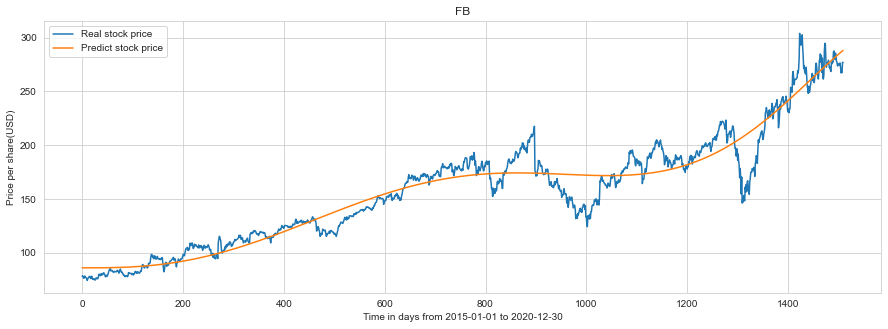

[*********************100%***********************]  1 of 1 completed
Best degree 5 with R^2: 0.9520584025216137 and RMSE: 65.53216538661108 and MAE: 49.69467576300797 and MSE: 4294.464700258149 and MAPE: 4.868774296894976


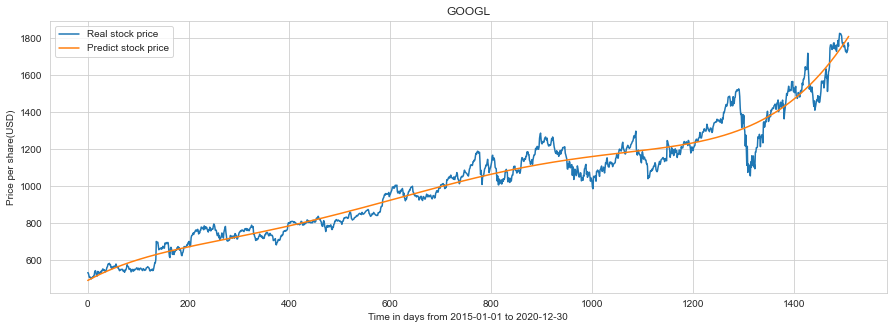

[*********************100%***********************]  1 of 1 completed
Best degree 5 with R^2: 0.9546760467048149 and RMSE: 65.27187709074802 and MAE: 49.303086370173 and MSE: 4260.417938949717 and MAPE: 4.886849396845398


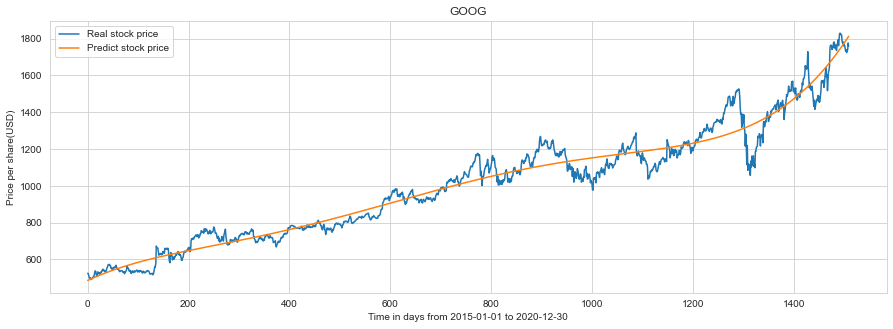

[*********************100%***********************]  1 of 1 completed
Best degree 8 with R^2: 0.8526154862491904 and RMSE: 8.613141318295911 and MAE: 6.675427332588985 and MSE: 74.18620336893622 and MAPE: 7.292040476285151


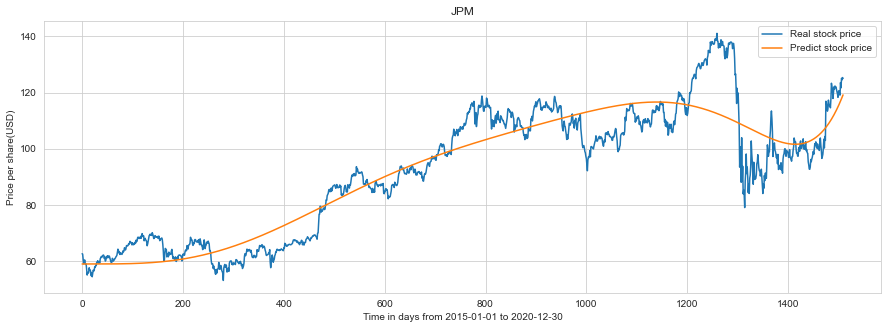

[*********************100%***********************]  1 of 1 completed
Best degree 5 with R^2: 0.8800682525662616 and RMSE: 5.705971670588851 and MAE: 4.485272797374275 and MSE: 32.55811270556252 and MAPE: 3.525326203156747


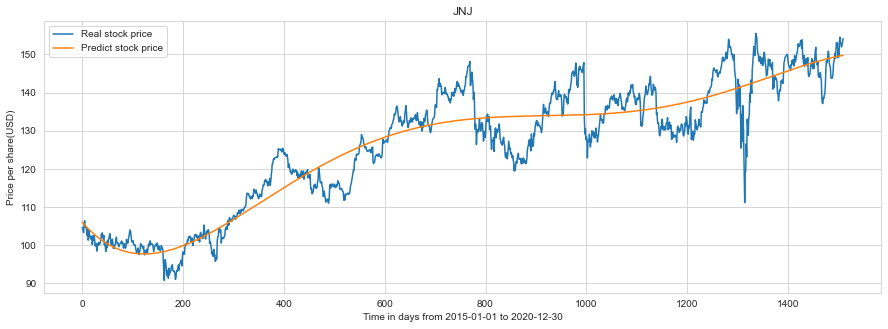

[*********************100%***********************]  1 of 1 completed
Best degree 7 with R^2: 0.9723166650679401 and RMSE: 18.353163329666277 and MAE: 10.068416042085667 and MSE: 336.8386042054069 and MAPE: 11.042619216510484


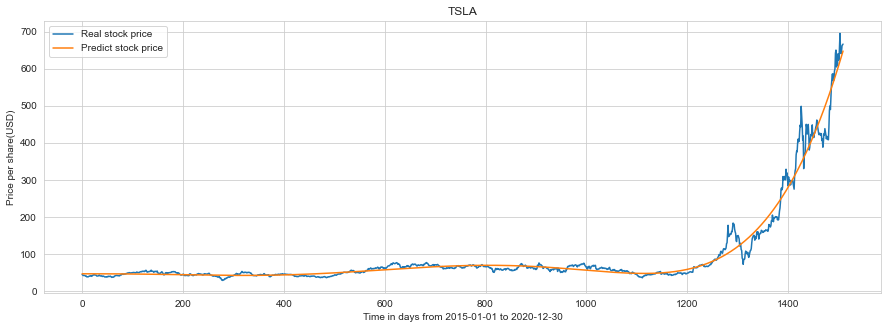

In [31]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

for company in companies:
  close_data,train_data,val_data,test_data = data_load_and_split(company, start, end)
  optimizedlinearregression(close_data.reset_index(),company)

# ARIMA

In [ ]:
#example
company = 'MSFT'
start = "2015-01-01"
end="2020-12-30"
data_load_and_train_test_split(company,start,end)

[*********************100%***********************]  1 of 1 completed
Orignal data shape: (1509, 7) 
 Close Dataframe shape: (1509, 1) 
 Training set shape: (1258, 1) 
 Testing set shape: (251, 1)


## Number of Differencing

In [ ]:
def num_diff(stock):
  '''
  estimate the number of differencing.
  '''
  kpss_diffs = ndiffs(stock, test='kpss')
  adf_diffs = ndiffs(stock, test="adf")
  return max(adf_diffs, kpss_diffs)

In [ ]:
#example
# n_diffs = num_diff(close_data)
n_diffs = num_diff(train)

## Check if Stationary

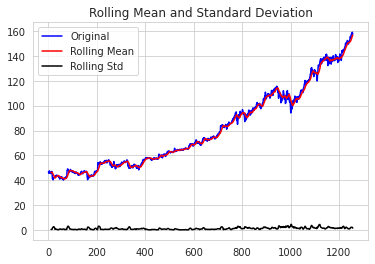

Results of dickey fuller test
Test Statistics                   2.130161
p-value                           0.998820
No. of lags used                  8.000000
Number of observations used    1249.000000
critical value (1%)              -3.435596
critical value (5%)              -2.863857
critical value (10%)             -2.568004
dtype: float64


In [ ]:
def test_stationarity(timeseries):
  '''
  Performs test statistics. If test statistics is bigger 
  than critical value and p-value is bigger than 0.05
  then this timeseries is not stationary
  '''
 #Determing rolling statistics
  rolmean = timeseries.rolling(12).mean()
  rolstd = timeseries.rolling(12).std()

  plt.plot(timeseries, color='blue',label='Original')
  plt.plot(rolmean, color='red', label='Rolling Mean')
  plt.plot(rolstd, color='black', label = 'Rolling Std')
  plt.legend(loc='best')
  plt.title('Rolling Mean and Standard Deviation')
  plt.show(block=False)
  

  print('Results of dickey fuller test')
  adft = adfuller(timeseries,autolag='AIC')
  output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
  for key,values in adft[4].items():
    output['critical value (%s)'%key] = values
  print(output)
 
test_stationarity(train)

In [ ]:
# Define train_log for seasonality removal

train_log = train.apply(lambda x : np.log(x))

train_log.head()

,Close
0,3.845028
1,3.835790
2,3.821004
3,3.833629
4,3.862623


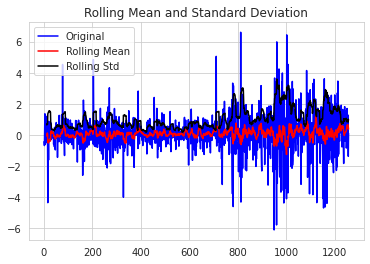

Results of dickey fuller test
Test Statistics               -1.502268e+01
p-value                        1.016923e-27
No. of lags used               7.000000e+00
Number of observations used    1.249000e+03
critical value (1%)           -3.435596e+00
critical value (5%)           -2.863857e+00
critical value (10%)          -2.568004e+00
dtype: float64


In [ ]:
# Remove seasonality
train_log_diff = train - train.shift(n_diffs) 
test_stationarity(train_log_diff.dropna())

## Auto Arima

In Auto ARIMA, the model itself will generate the optimal p, d, and q values which would be suitable for the data set to provide better forecasting

https://towardsdatascience.com/time-series-forecasting-using-auto-arima-in-python-bb83e49210cd

In [ ]:
def arima_auto(stock):
  
  global arima_model
  arima_model = auto_arima(
      stock,
      start_p=0,
      start_q=0,
      test="adf",
      max_p=6,
      max_q=6,
      m=1,  # frequency of series
      d=n_diffs, 
      seasonal=False,  # no seasonality
      trace=True,
      stepwise=True,
      njob=-1,
  )
  print(arima_model.summary())
  return arima_model

In [ ]:
#example
arima_model = arima_auto(train_log_diff.dropna())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5060.539, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4691.157, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5058.539, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4435.694, Time=0.23 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4365.022, Time=0.30 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=4332.469, Time=0.40 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=4286.883, Time=0.49 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=4227.973, Time=0.67 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=4.59 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=3.83 sec
 ARIMA(6,1,0)(0,0,0)[0]             : AIC=4225.973, Time=0.32 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=4284.883, Time=0.22 sec
 ARIMA(6,1,1)(0,0,0)[0]             : AIC=inf, Time=1.44 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=1

## Arima Model

In [ ]:
def run_arima(company, start, end):
  # Make first prediction
  data_load_and_train_test_split(company, start, end)
  history = [x for x in train.Close]
  y = test.Close  
  predictions = list()
  model = ARIMA(train, order=(0, 1, 0))
  model_fit = model.fit(disp=0)
  yhat = model_fit.forecast()[0][0]
  predictions.append(yhat)
  history.append(y[0])

  # Rolling forecasts
  for i in range(1, len(y)):
    # Predict
    model = ARIMA(train, order=(0, 1, 0))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0][0]
    # Invert transformed prediction
    predictions.append(yhat)
    # Observation
    obs = y[i]
    history.append(obs)

  # Report performance
  mse = mean_squared_error(y, predictions)
  print('MSE: ' + str(mse))
  mae = mean_absolute_error(y, predictions)
  print('MAE: ' + str(mae))
  rmse = math.sqrt(mean_squared_error(y, predictions))
  print('RMSE: ' + str(rmse))
  return mse, mae, rmse, history, predictions

In [ ]:
def plot_arima(company, start, end):  
  mse, mae, rmse, history, predictions = run_arima(company, start, end)
  # Plotting ARIMA result
  fig = go.Figure()

  fig.add_trace(go.Scatter(x=train[-250:], y=train[250:], mode='lines', name='Price'))
  fig.add_trace(go.Scatter(x=test, y=test, mode='lines', name='Test price'))
  fig.add_trace(go.Scatter(x=test, y=predictions, mode='lines', name=f'Predicted price of {company}'))

  fig.update_layout(autosize=True, width=1450, height=825,
      title_font=dict(size=25, family='Courier', color='crimson'),
      title=f"ARIMA prediction - Close Price - {company}",
  )

  fig.show()
  return [mse, mae, rmse]

In [ ]:
def get_arima_results(companies, start, end):
  results = []
  titles = ['Stock', 'MSE', 'MAE']
  for company in companies:
    row = plot_arima(company, start, end)
    

In [ ]:
test[0:1]

,Close
1258,160.619995


In [ ]:
train = train.values
# Create list of x train values
history = [x for x in train]
# establish list for predictions
model_predictions = []
# Count number of test data points
N_test_observations = len(test)

# loop through every data point
for time_point in list(test.index):
    model = ARIMA(history, order=(6,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test[time_point-1258:time_point-1257]
    history.append(true_test_value)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



In [ ]:
RMSE_error = np.sqrt(mean_squared_error(test, model_predictions))
print('Test Score: %.2f RMSE' % RMSE_error)

Test Score: 4.66 RMSE


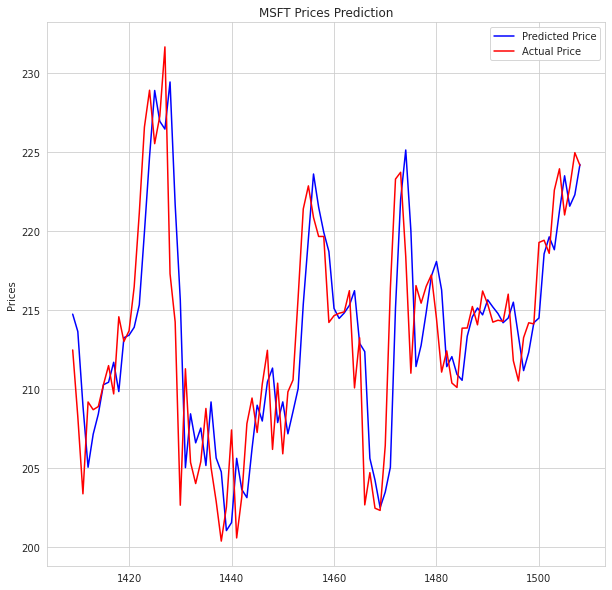

<Figure size 720x432 with 0 Axes>

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(test.index[-100:], model_predictions[-100:], color='blue',label='Predicted Price')
plt.plot(test.index[-100:], test[-100:], color='red', label='Actual Price')
plt.title(company + ' Prices Prediction')
plt.ylabel('Prices')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

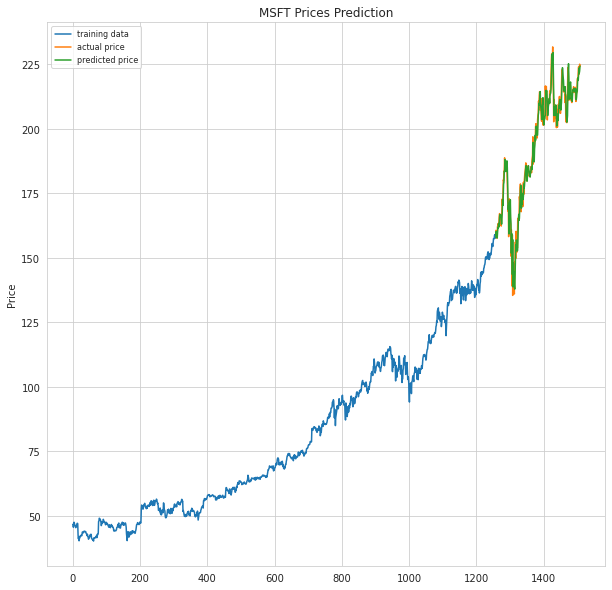

In [ ]:
plt.plot(train, label='training data')
plt.plot(test, label='actual price')
plt.plot(test.index[-len(test):],model_predictions[-len(test):], label='predicted price')
plt.ylabel('Price')
plt.title(company + ' Prices Prediction')
plt.legend(loc='upper left', fontsize=8)
plt.show()

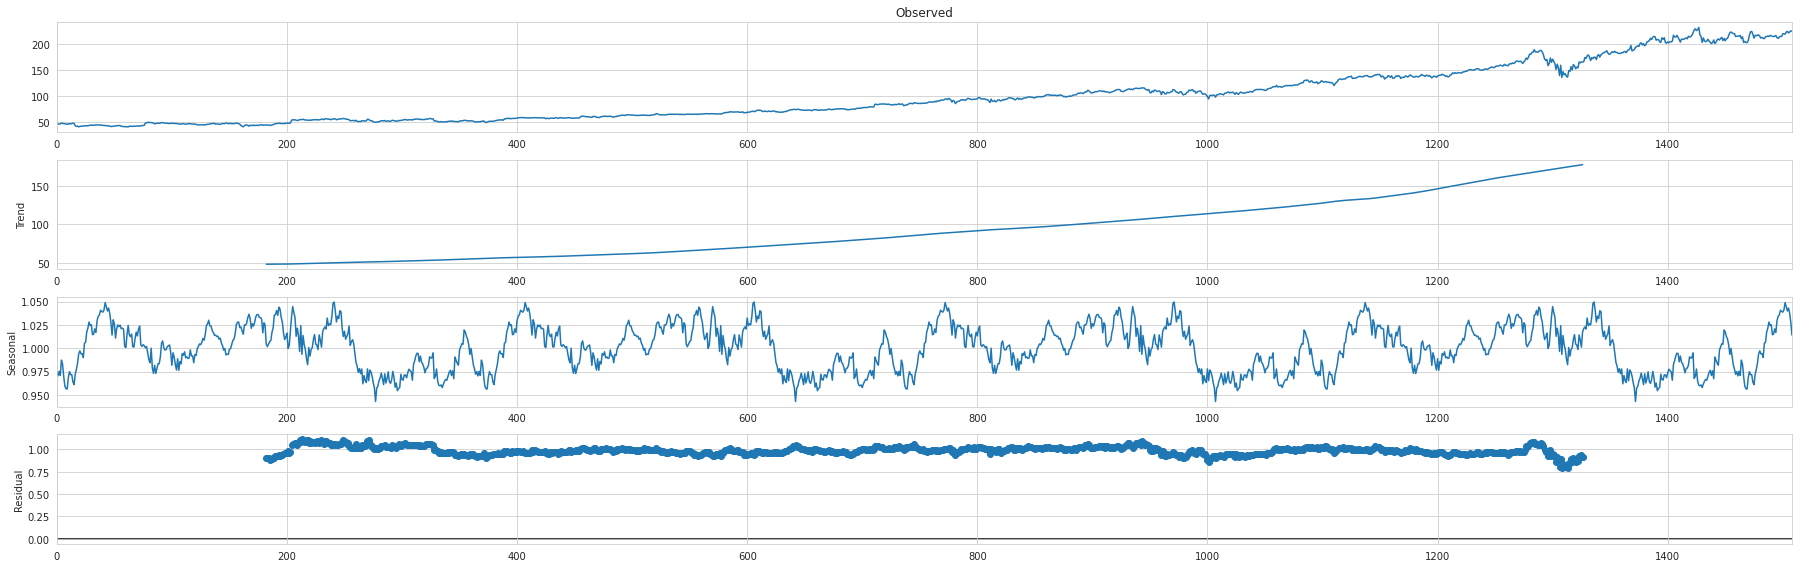

In [ ]:

rcParams['figure.figsize'] = 25, 8

valuessarima =close_data.values
train = train
test = test

result = seasonal_decompose(valuessarima, model='multiplicative', freq=365)
fig = result.plot()
plt.show()


In [ ]:
type(test)

pandas.core.frame.DataFrame

# LSTMs

## Pre-processing 

same for all lstm models

In [43]:
# Define optimiser and callbacks for all LSTMs
opt = Adam(0.0001)
callbacks = [ EarlyStopping(monitor='val_loss', mode='min', patience=10)]

#  Define Scaler 
scaler = MinMaxScaler(feature_range = (0,1))

In [44]:
# functions used 

def supervised(data, num_timesteps=60, n_out = 1, dropnan = True):
  '''
  Converts time series into a supervised learning problem 
  '''
  # make data into a dataframe 
  data = pd.DataFrame(data)
  
  n_variables = 1 # i.e. number of features in this case we have chosen 'Close' 
  columns, names = list(),list()

  # input data
  for i in range(num_timesteps, 0, -1):
    columns.append(data.shift(i))
    names += [('var%d(t-%d')%(j+1,i) for j in range(n_variables)]

  # target data (forecast)
  for i in range(0, n_out):
    columns.append(data.shift(-i))
    if i ==0:
      names += [('var%d(t)' % (j+1)) for j in range(n_variables)]
    else:
      names += [('var%d(t+%d )' % (j+1, i)) for j in range(n_variables)]

  # combine the two
  df = pd.concat(columns, axis = 1)
  df.columns = names

  # drop missing data rows 
  if dropnan:
    df.dropna(inplace = True)

  return df


In [45]:

def split_and_reshape(data, num_timesteps=60, num_features=1):
  '''
  scales and reshapes data into required shape for LSTM in keras

  '''

 # get data values 
  values = data.values

  # split into x and y 
  X, y = values[:, :-1], values[:,-1]

  # reshape into 3D form
  X = np.reshape(X, (X.shape[0], num_timesteps, num_features ))

  
  print('X shape:',X.shape, '\ny shape:', y.shape)

  return X, y

## Plot LSTM Performance

In [46]:
# Plotting performance 
# https://github.com/gcarq/keras-timeseries-prediction/blob/master/main.py
def plot_data(dataset: np.ndarray,
              company: str,
              measure: str,
              timestep: int,
              model_type:str,
              train_predict: np.ndarray,
              test_predict: np.ndarray,
              val_predict: np.ndarray):
             # forecast_predict=: np.ndarray):
    """
    Plots baseline and predictions
    Leaves gaps for the first time steps necessary for predictions
    light grey: baseline
    dashed black: prediction with training data
    dashed blue: prediction with test data
    dashed green: prediction based on predictions
    :param dataset: initial dataset
    :param company: name of company on the stock market,
    :param measure: names of measure studied,
    :param timestep: number of time steps necessary for prediction
    :param train_predict: predicted values based on training data
    :param test_predict: predicted values based on test data
    :param forecast_predict: predicted values based on previous predictions, default empty, 
    :return: None
    """
    plt.plot(dataset, color='lightgrey')
    plt.plot( [None for _ in range(timestep)] +
             [x for x in train_predict], '--', color='black')
    plt.plot([None for _ in range(timestep)] +
             # added for dimensionality, as length of train, val, and test sets 
             # does not include the first 'timesteps' for its predictions  
             [None for _ in range(timestep)] +
             [None for _ in train_predict] +
             [x for x in val_predict], '--', color='royalblue')
    plt.plot([None for _ in range(timestep)] +
             # added for dimensionality, as length of train, val, and test sets 
             # does not include the first 'timesteps' for its predictions  
             [None for _ in range(timestep)] + 
             [None for _ in train_predict] +
             # added for dimensionality, as length of train, val, and test sets 
             # does not include the first 'timesteps' for its predictions  
             [None for _ in range(timestep)] +
             [None for _ in val_predict] +
             [x for x in test_predict], '--', color='green')
    

    plt.title(f'{company} Stock Price Prediction using {model_type}')
    plt.xlabel('Time')
    plt.ylabel(f'{company} Stock Price')
    plt.legend(['dataset', 'train predict', 'train predict + val predict','train + val + test predict'])
    plt.show()

## Evaluating LSTM Performance

In [47]:
def get_predictions(model, X_train, X_val, X_test):
  '''
  Feeds data into pre-trained model and returns predictions
    :param model: compiled and trained model to be used for predictions
    :param X_train: training dataset X
    :param X_val: validation dataset X
    :param X_test: test dataset X
    :return:  train_predict: predictictions for training data
              test_predict: predictions for test data
              val_predict: predictions for validation data
  '''
  train_predict = model.predict(X_train)
  val_predict = model.predict(X_val)
  test_predict = model.predict(X_test)
  
  return train_predict, val_predict, test_predict


def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test):
  '''
  Obtain predictions, invert data and predictions, calculate metrics for evaluation
    :param model: compiled and trained model to be used for predictions
    :param X_train: training dataset X
    :param y_train: training dataset Y
    :param X_val: validation dataset X
    :param y_val: validation dataset y
    :param X_test: test dataset X
    :param y_test: test dataset y
  '''
  train_predict = model.predict(X_train)
  test_predict = model.predict(X_test)
  val_predict = model.predict(X_val)
  # invert dataset and predictions
  train_predict = scaler.inverse_transform(train_predict)
  train_y = scaler.inverse_transform([y_train])
  test_predict = scaler.inverse_transform(test_predict)
  test_y = scaler.inverse_transform([y_test])
  val_predict = scaler.inverse_transform(val_predict)
  val_y = scaler.inverse_transform([y_val])

  #forecast_predict = scaler.inverse_transform(forecast_predict)
  train_score = np.sqrt(mean_squared_error(train_y[0], train_predict[:, 0]))
  print('Train Score: %.2f RMSE' % train_score)
  test_score = np.sqrt(mean_squared_error(test_y[0], test_predict[:, 0]))
  print('Test Score: %.2f RMSE' % test_score)

## Simple LSTM  



In [50]:
# test values for num_units 
#num_units = 50 
num_units = 128
#LSTM implementaiton
regressor = Sequential()
regressor.add(LSTM(num_units, input_shape = (X_train.shape[1], 1)))
#regressor.add(Dropout(0.2))
regressor.add(Dense(1))
regressor.compile(loss='mse', optimizer=opt)
plot_model(regressor, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


### Optimised

https://www.tensorflow.org/tutorials/keras/keras_tuner

https://datascience.stackexchange.com/questions/73605/opinions-on-an-lstm-hyper-parameter-tuning-process-i-am-using



In [63]:
!pip install -q -U keras-tuner
import tensorflow as tf
from tensorflow import keras

In [65]:
from tensorflow import keras
from kerastuner.tuners import BayesianOptimization

In [66]:
def build(hp):


    activation = hp.Choice('activation', 
                        [
                          'relu',
                          'tanh',
                          'linear',
                          'selu',
                          'elu'
                        ])

    recurrent_dropout = hp.Float(
                        'recurrent_dropout', 
                        min_value=0.0,
                        max_value=0.99,
                        default=0.2)
    num_units = hp.Int(
                        'num_units', 
                        min_value=0,
                        max_value=64,
                        default=32)
    
    model = Sequential()
    model.add(LSTM(units=num_units, activation=activation, recurrent_dropout = recurrent_dropout,input_shape=(X_train.shape[1], 1)))

    model.add(Dense(1))

    model.compile(
      optimizer=keras.optimizers.Adam(
      hp.Float(
        'learning_rate',
        min_value=1e-10,
        max_value=1e-2,
        sampling='LOG',
        default=1e-6
            ),

        ),
        loss=tf.losses.MeanSquaredError(),
        metrics=[tf.metrics.MeanAbsoluteError()]
    )
    return model

bayesian_opt_tuner = BayesianOptimization(
    build,
    objective="val_loss",
    max_trials=3,
    executions_per_trial=1,
    directory=os.path.normpath('C:/keras_tuning'),
    project_name='kerastuner_bayesian_poc',
    overwrite=True)
n_epochs=100
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)





Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
activation        |elu               |?                 
recurrent_dropout |0.012747          |?                 
num_units         |19                |?                 
learning_rate     |0.0023078         |?                 

Epoch 1/100
24/24 [==============================] - 3s 34ms/step - loss: 0.1283 - mean_absolute_error: 0.2723 - val_loss: 0.0061 - val_mean_absolute_error: 0.0621
Epoch 2/100
24/24 [==============================] - 1s 21ms/step - loss: 0.0111 - mean_absolute_error: 0.0882 - val_loss: 0.0179 - val_mean_absolute_error: 0.0989
Epoch 3/100
24/24 [==============================] - 1s 22ms/step - loss: 0.0026 - mean_absolute_error: 0.0418 - val_loss: 0.1999 - val_mean_absolute_error: 0.3258
Epoch 4/100
24/24 [==============================] - 1s 21ms/step - loss: 0.0016 - mean_absolute_error: 0.0324 - val_loss: 0.0489 - val_mean_absolute_error: 0.1676
Epoch 5/100
24/24 [============

Epoch 90/100
24/24 [==============================] - 1s 21ms/step - loss: 0.3708 - mean_absolute_error: 0.5159 - val_loss: 1.9183 - val_mean_absolute_error: 1.3593
Epoch 91/100
24/24 [==============================] - 1s 21ms/step - loss: 0.3605 - mean_absolute_error: 0.5014 - val_loss: 1.9183 - val_mean_absolute_error: 1.3593
Epoch 92/100
24/24 [==============================] - 1s 21ms/step - loss: 0.3583 - mean_absolute_error: 0.5043 - val_loss: 1.9183 - val_mean_absolute_error: 1.3593
Epoch 93/100
24/24 [==============================] - 1s 21ms/step - loss: 0.3540 - mean_absolute_error: 0.5013 - val_loss: 1.9182 - val_mean_absolute_error: 1.3593
Epoch 94/100
24/24 [==============================] - 1s 21ms/step - loss: 0.3588 - mean_absolute_error: 0.5014 - val_loss: 1.9182 - val_mean_absolute_error: 1.3593
Epoch 95/100
24/24 [==============================] - 1s 21ms/step - loss: 0.3648 - mean_absolute_error: 0.5077 - val_loss: 1.9182 - val_mean_absolute_error: 1.3593
Epoch 96/1

NameError: name 'model' is not defined

[*********************100%***********************]  1 of 1 completed
X shape: (947, 60, 1) 
y shape: (947,)
X shape: (192, 60, 1) 
y shape: (192,)
X shape: (191, 60, 1) 
y shape: (191,)
INFO:tensorflow:Oracle triggered exit


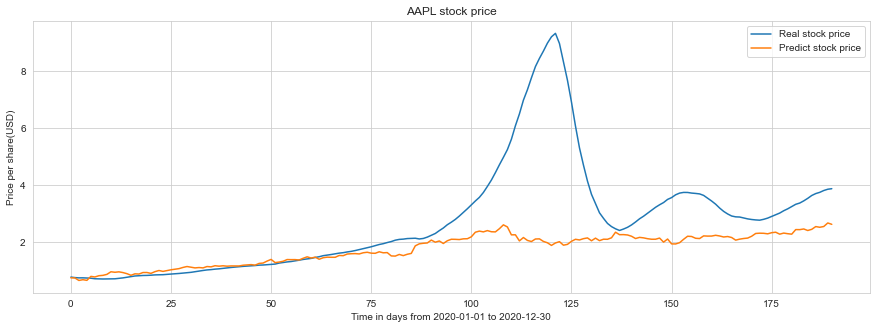

Train Score: 4.60 RMSE
Test Score: 72.53 RMSE
MAE: 1.0415731315581558 and MSE: 3.6687784926934084 and MAPE: 59.75393379202488
[*********************100%***********************]  1 of 1 completed
X shape: (947, 60, 1) 
y shape: (947,)
X shape: (192, 60, 1) 
y shape: (192,)
X shape: (191, 60, 1) 
y shape: (191,)
INFO:tensorflow:Oracle triggered exit


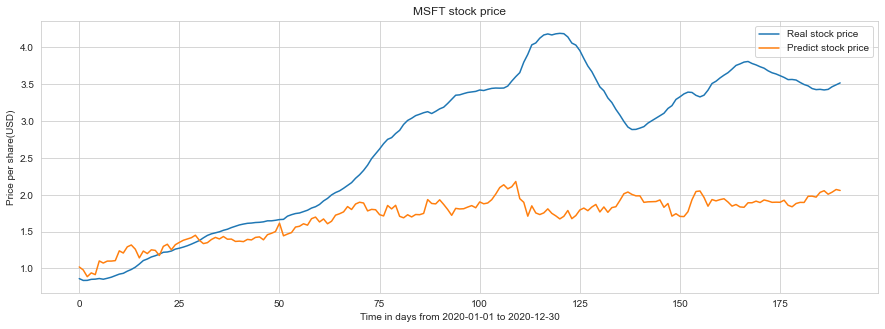

Train Score: 6.91 RMSE
Test Score: 78.36 RMSE
MAE: 1.0344699136405182 and MSE: 1.6201769228756753 and MAPE: 45.138766485053694
[*********************100%***********************]  1 of 1 completed
X shape: (947, 60, 1) 
y shape: (947,)
X shape: (192, 60, 1) 
y shape: (192,)
X shape: (191, 60, 1) 
y shape: (191,)
INFO:tensorflow:Oracle triggered exit


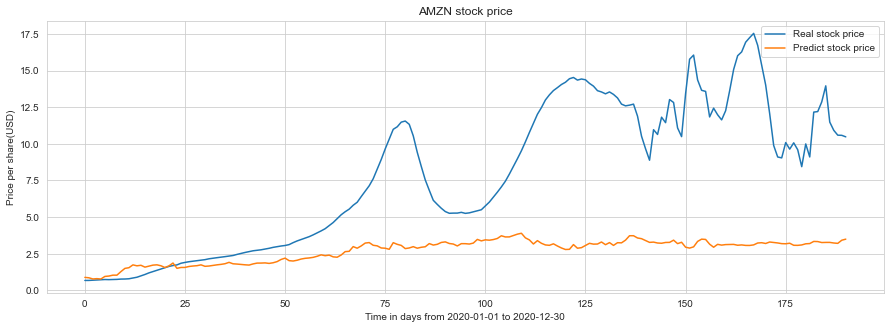

Train Score: 53.84 RMSE
Test Score: 3491.20 RMSE
MAE: 5.235123044326193 and MSE: 44.95293201338257 and MAPE: 78.73191121090032
[*********************100%***********************]  1 of 1 completed
X shape: (947, 60, 1) 
y shape: (947,)
X shape: (192, 60, 1) 
y shape: (192,)
X shape: (191, 60, 1) 
y shape: (191,)
INFO:tensorflow:Oracle triggered exit


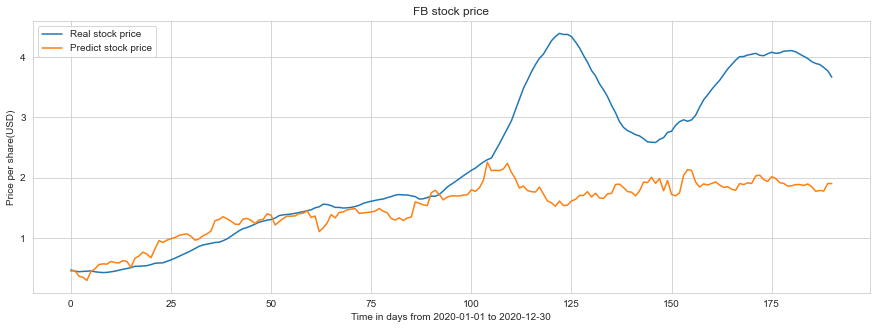

Train Score: 7.54 RMSE
Test Score: 93.05 RMSE
MAE: 0.850927124394912 and MSE: 1.4850137674587098 and MAPE: 69.21404237977407
[*********************100%***********************]  1 of 1 completed
X shape: (947, 60, 1) 
y shape: (947,)
X shape: (192, 60, 1) 
y shape: (192,)
X shape: (191, 60, 1) 
y shape: (191,)
INFO:tensorflow:Oracle triggered exit


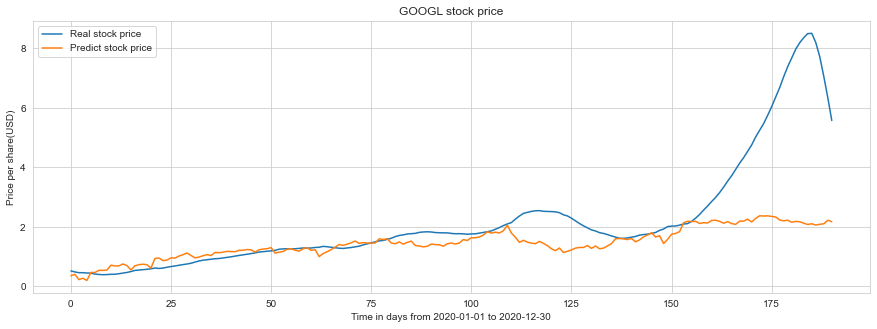

Train Score: 29.09 RMSE
Test Score: 566.37 RMSE
MAE: 0.8294761100106249 and MSE: 2.824444507964672 and MAPE: 65.3016379829579
[*********************100%***********************]  1 of 1 completed
X shape: (947, 60, 1) 
y shape: (947,)
X shape: (192, 60, 1) 
y shape: (192,)
X shape: (191, 60, 1) 
y shape: (191,)
INFO:tensorflow:Oracle triggered exit


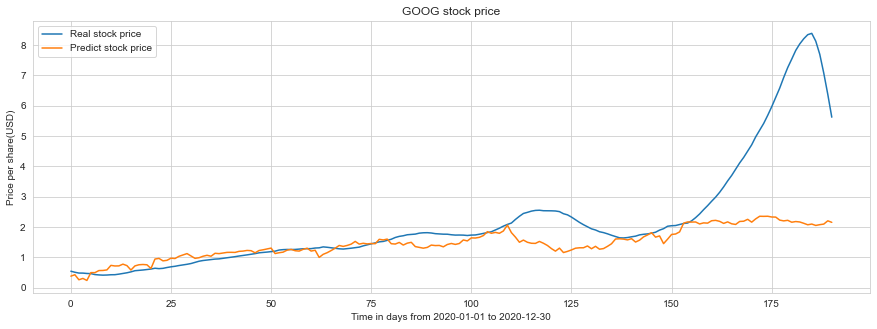

Train Score: 31.04 RMSE
Test Score: 571.34 RMSE
MAE: 0.8193306258814652 and MSE: 2.7407391417687776 and MAPE: 63.281444657821176
[*********************100%***********************]  1 of 1 completed
X shape: (947, 60, 1) 
y shape: (947,)
X shape: (192, 60, 1) 
y shape: (192,)
X shape: (191, 60, 1) 
y shape: (191,)
INFO:tensorflow:Oracle triggered exit


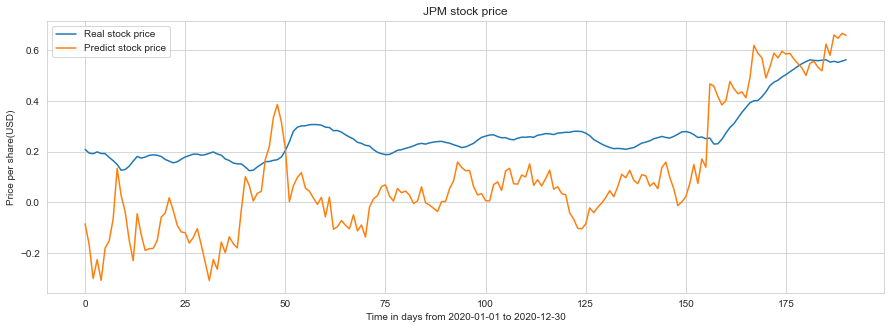

Train Score: 4.47 RMSE
Test Score: 9.87 RMSE
MAE: 0.20563140877208472 and MSE: 0.054423955013558505 and MAPE: 106.91559480652695
[*********************100%***********************]  1 of 1 completed
X shape: (947, 60, 1) 
y shape: (947,)
X shape: (192, 60, 1) 
y shape: (192,)
X shape: (191, 60, 1) 
y shape: (191,)
INFO:tensorflow:Oracle triggered exit


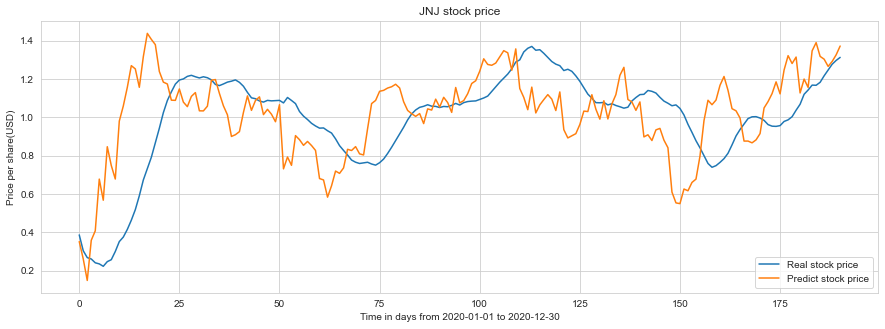

Train Score: 2.03 RMSE
Test Score: 5.26 RMSE
MAE: 0.19177305123326985 and MSE: 0.06449597515014588 and MAPE: 38.03410303747758
[*********************100%***********************]  1 of 1 completed
X shape: (947, 60, 1) 
y shape: (947,)
X shape: (192, 60, 1) 
y shape: (192,)
X shape: (191, 60, 1) 
y shape: (191,)
INFO:tensorflow:Oracle triggered exit


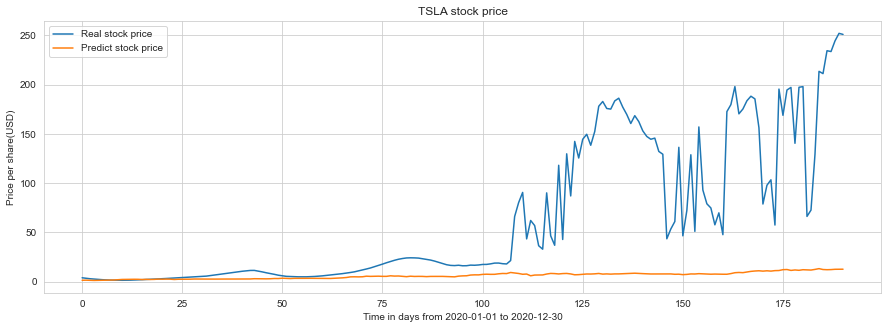

Train Score: 5.14 RMSE
Test Score: 4541.81 RMSE
MAE: 57.13751091950969 and MSE: 8122.687714315454 and MAPE: 92.11844648114277


In [93]:
# example
for company in companies:
    close_data, train_data, val_data, test_data = data_load_and_split(
        company, start, end)
    train_scaled = scaler.fit_transform(train_data)
    train_supervised = supervised(train_scaled)
    X_train, y_train = split_and_reshape(train_supervised)

    # create validation data
    val_scaled = scaler.fit_transform(val_data)
    val_supervised = supervised(val_scaled)
    X_val, y_val = split_and_reshape(val_supervised)

    # create test data
    test_scaled = scaler.transform(test_data)  # transform not fit_transform
    test_supervised = supervised(test_scaled)
    X_test, y_test = split_and_reshape(test_supervised)

    bayesian_opt_tuner.search(X_train, y_train, epochs=n_epochs,
                              validation_data=(X_val, y_val),
                              validation_split=0.2, verbose=1,
                              callbacks=[stop_early])

    bayes_opt_model_best_model = bayesian_opt_tuner.get_best_models(
        num_models=1)
    model = bayes_opt_model_best_model[0]

    plt.figure(figsize=(15, 5))
    plt.plot(model.predict(X_test), label='Real stock price')
    plt.plot(y_test, label='Predict stock price')
    plt.title(company+ ' stock price')
    plt.xlabel('Time in days from 2020-01-01 to 2020-12-30')
    plt.ylabel('Price per share(USD)')
    plt.legend()
    plt.show()
  
  


    evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test)
    mse=mean_squared_error(model.predict(X_test), y_test)
    mae=mean_absolute_error(model.predict(X_test),y_test)
    mape=mean_absolute_percentage_error(model.predict(X_test),y_test)
    print('MAE: {} and MSE: {} and MAPE: {}' .format(mae,mse,mape))

## Stacked LSTMs

In [94]:
# Uses the same preprocessing as LSTM
#Example
company = 'AAPL'
start = "2015-01-01"
end="2020-12-30"

#load data 
data_load_and_split(company,start,end)

[*********************100%***********************]  1 of 1 completed


(           Close
 0      27.594999
 1      27.332500
 2      26.562500
 3      26.565001
 4      26.937500
 ...          ...
 1505  131.880005
 1506  130.960007
 1507  131.970001
 1508  136.690002
 1509  134.869995
 
 [1510 rows x 1 columns],
           Close
 0     27.594999
 1     27.332500
 2     26.562500
 3     26.565001
 4     26.937500
 ...         ...
 1002  36.707500
 1003  39.292500
 1004  39.037498
 1005  39.057499
 1006  39.435001
 
 [1007 rows x 1 columns],
           Close
 1007  39.480000
 1008  35.547501
 1009  37.064999
 1010  36.982498
 1011  37.687500
 ...         ...
 1254  71.067497
 1255  72.477501
 1256  72.449997
 1257  72.879997
 1258  73.412498
 
 [252 rows x 1 columns],
            Close
 1259   75.087502
 1260   74.357498
 1261   74.949997
 1262   74.597504
 1263   75.797501
 ...          ...
 1505  131.880005
 1506  130.960007
 1507  131.970001
 1508  136.690002
 1509  134.869995
 
 [251 rows x 1 columns])

In [95]:
# Scaling data 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))

#create training data
train_scaled = scaler.fit_transform(train)
train_supervised = supervised(train_scaled)
X_train, y_train = split_and_reshape(train_supervised)

# create validation data
val_scaled = scaler.fit_transform(val) 
val_supervised = supervised(val_scaled)
X_val, y_val = split_and_reshape(val_supervised)

# create test data
test_scaled = scaler.transform(test) # transform not fit_transform
test_supervised = supervised(test_scaled)
X_test, y_test = split_and_reshape(test_supervised)

X shape: (947, 60, 1) 
y shape: (947,)
X shape: (192, 60, 1) 
y shape: (192,)
X shape: (191, 60, 1) 
y shape: (191,)


In [96]:
#num_units = 50 
num_units = 128
#LSTM implementaiton
model= Sequential()
model.add(LSTM(units = num_units , return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = num_units , return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = num_units , return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = num_units ))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

model.compile(optimizer=opt, metrics='mse', loss='mean_squared_error')

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [97]:
# model summary and fit
model.summary()
history = model.fit(X_train,y_train, callbacks=callbacks,validation_data=(X_val,y_val), epochs=100,batch_size=64,verbose=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 128)           66560     
_________________________________________________________________
dropout (Dropout)            (None, 60, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 60, 128)           131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)              

In [98]:
evaluate_model(model,X_train,y_train,X_val,y_val,X_test,y_test)

Train Score: 1.59 RMSE
Test Score: 14.77 RMSE


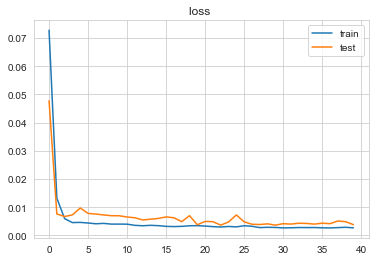

In [99]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('loss ')
plt.legend()
plt.show()

In [100]:
#predictions and check performance metrics
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
val_predict = model.predict(X_val)

# invert dataset and predictions
train_predict = scaler.inverse_transform(train_predict)
train_y = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
test_y = scaler.inverse_transform([y_test])
val_predict = scaler.inverse_transform(val_predict)
val_y = scaler.inverse_transform([y_val])

#forecast_predict = scaler.inverse_transform(forecast_predict)
train_score = np.sqrt(mean_squared_error(train_y[0], train_predict[:, 0]))
print('Train Score: %.2f RMSE' % train_score)
test_score = np.sqrt(mean_squared_error(test_y[0], test_predict[:, 0]))
print('Test Score: %.2f RMSE' % test_score)

Train Score: 1.59 RMSE
Test Score: 14.77 RMSE


In [101]:
plot_data(close_data,look_back=60,train_predict=train_predict,test_predict=test_predict, val_predict=val_predict)

TypeError: plot_data() got an unexpected keyword argument 'look_back'

In [ ]:
#show actual and predicted price
plt.plot(inv_y,  label = company + ' actual close')
plt.plot(inv_test,  label = 'predicted')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
plt.plot(inv_y[:100], label = company + ' actual close')
plt.plot(inv_test[:100], label = 'predicted')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.show()

### Optimised

In [ ]:
def build(hp):


    activation = hp.Choice('activation', 
                        [
                          'relu',
                          'tanh',
                          'linear',
                          'selu',
                          'elu'
                        ])

    recurrent_dropout = hp.Float(
                        'recurrent_dropout', 
                        min_value=0.0,
                        max_value=0.99,
                        default=0.2)
    num_units = hp.Int(
                        'num_units', 
                        min_value=0,
                        max_value=64,
                        default=32)
    
    model = Sequential()
    model.add(LSTM(units=num_units, activation=activation,return_sequences = True, recurrent_dropout = recurrent_dropout,input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=num_units, activation=activation, recurrent_dropout = recurrent_dropout,return_sequences = True))
    model.add(LSTM(units=num_units, activation=activation, recurrent_dropout = recurrent_dropout,return_sequences = True))
    model.add(LSTM(units=num_units, activation=activation, recurrent_dropout = recurrent_dropout))
    model.add(Dense(1))

    model.compile(
      optimizer=keras.optimizers.Adam(
      hp.Float(
        'learning_rate',
        min_value=1e-10,
        max_value=1e-2,
        sampling='LOG',
        default=1e-6
            ),

        ),
        loss=tf.losses.MeanSquaredError(),
        metrics=[tf.metrics.MeanAbsoluteError()]
    )
    return model

bayesian_opt_tuner = BayesianOptimization(
    build,
    objective="val_loss",
    max_trials=3,
    executions_per_trial=1,
    directory=os.path.normpath('C:/keras_tuning'),
    project_name='kerastuner_bayesian_poc',
    overwrite=True)
n_epochs=100
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
bayesian_opt_tuner.search(X_train, y_train,epochs=n_epochs,
     validation_data=(X_val, y_val),
     validation_split=0.2,verbose=1,
     callbacks=[stop_early])


bayes_opt_model_best_model = bayesian_opt_tuner.get_best_models(num_models=1)
model = bayes_opt_model_best_model[0]


In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
evaluate_model(model,X_train,y_train,X_val,y_val,X_test,y_test)

[*********************100%***********************]  1 of 1 completed
X shape: (947, 60, 1) 
y shape: (947,)
X shape: (192, 60, 1) 
y shape: (192,)
X shape: (191, 60, 1) 
y shape: (191,)

Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
activation        |linear            |?                 
recurrent_dropout |0.91587           |?                 
num_units         |61                |?                 
learning_rate     |3.553e-09         |?                 

Epoch 1/100
24/24 [==============================] - 3s 37ms/step - loss: 0.0884 - mean_absolute_error: 0.2463 - val_loss: 0.4735 - val_mean_absolute_error: 0.6745
Epoch 2/100
24/24 [==============================] - 1s 24ms/step - loss: 0.0962 - mean_absolute_error: 0.2575 - val_loss: 0.4735 - val_mean_absolute_error: 0.6745
Epoch 3/100
24/24 [==============================] - 1s 27ms/step - loss: 0.0951 - mean_absolute_error: 0.2591 - val_loss: 0.4735 - val_mean_absolute_error: 0.6745
Epoch 4/1

Epoch 48/100
24/24 [==============================] - 1s 26ms/step - loss: 0.0948 - mean_absolute_error: 0.2585 - val_loss: 0.4733 - val_mean_absolute_error: 0.6743
Epoch 49/100
24/24 [==============================] - 1s 27ms/step - loss: 0.0939 - mean_absolute_error: 0.2541 - val_loss: 0.4733 - val_mean_absolute_error: 0.6743
Epoch 50/100
24/24 [==============================] - 1s 24ms/step - loss: 0.0931 - mean_absolute_error: 0.2561 - val_loss: 0.4733 - val_mean_absolute_error: 0.6743
Epoch 51/100
24/24 [==============================] - 1s 23ms/step - loss: 0.0867 - mean_absolute_error: 0.2449 - val_loss: 0.4733 - val_mean_absolute_error: 0.6743
Epoch 52/100
24/24 [==============================] - 1s 22ms/step - loss: 0.0882 - mean_absolute_error: 0.2469 - val_loss: 0.4733 - val_mean_absolute_error: 0.6743
Epoch 53/100
24/24 [==============================] - 1s 24ms/step - loss: 0.0924 - mean_absolute_error: 0.2531 - val_loss: 0.4733 - val_mean_absolute_error: 0.6743
Epoch 54/1

Epoch 98/100
24/24 [==============================] - 1s 23ms/step - loss: 0.0876 - mean_absolute_error: 0.2482 - val_loss: 0.4731 - val_mean_absolute_error: 0.6742
Epoch 99/100
24/24 [==============================] - 1s 23ms/step - loss: 0.0873 - mean_absolute_error: 0.2458 - val_loss: 0.4731 - val_mean_absolute_error: 0.6742
Epoch 100/100
24/24 [==============================] - 1s 23ms/step - loss: 0.0880 - mean_absolute_error: 0.2470 - val_loss: 0.4731 - val_mean_absolute_error: 0.6742

Trial 1 Complete [00h 01m 05s]
val_loss: 0.47309964895248413

Best val_loss So Far: 0.47309964895248413
Total elapsed time: 00h 01m 05s

Search: Running Trial #2

Hyperparameter    |Value             |Best Value So Far 
activation        |linear            |linear            
recurrent_dropout |0.80575           |0.91587           
num_units         |24                |61                
learning_rate     |1.6695e-05        |3.553e-09         

Epoch 1/100
24/24 [==============================] - 3

Epoch 45/100
24/24 [==============================] - 0s 21ms/step - loss: 0.0166 - mean_absolute_error: 0.0986 - val_loss: 0.0337 - val_mean_absolute_error: 0.1639
Epoch 46/100
24/24 [==============================] - 0s 21ms/step - loss: 0.0215 - mean_absolute_error: 0.1079 - val_loss: 0.0328 - val_mean_absolute_error: 0.1614
Epoch 47/100
24/24 [==============================] - 0s 21ms/step - loss: 0.0171 - mean_absolute_error: 0.0985 - val_loss: 0.0319 - val_mean_absolute_error: 0.1589
Epoch 48/100
24/24 [==============================] - 1s 21ms/step - loss: 0.0171 - mean_absolute_error: 0.0998 - val_loss: 0.0306 - val_mean_absolute_error: 0.1554
Epoch 49/100
24/24 [==============================] - 0s 21ms/step - loss: 0.0169 - mean_absolute_error: 0.0945 - val_loss: 0.0329 - val_mean_absolute_error: 0.1620
Epoch 50/100
24/24 [==============================] - 1s 21ms/step - loss: 0.0169 - mean_absolute_error: 0.0976 - val_loss: 0.0301 - val_mean_absolute_error: 0.1540
Epoch 51/1

Epoch 5/100
24/24 [==============================] - 0s 20ms/step - loss: 19.2798 - mean_absolute_error: 0.4983 - val_loss: 0.2405 - val_mean_absolute_error: 0.4793
Epoch 6/100
24/24 [==============================] - 0s 20ms/step - loss: 7.8737 - mean_absolute_error: 0.4392 - val_loss: 0.2358 - val_mean_absolute_error: 0.4742

Trial 3 Complete [00h 00m 05s]
val_loss: 0.18258963525295258

Best val_loss So Far: 0.013203213922679424
Total elapsed time: 00h 02m 00s
INFO:tensorflow:Oracle triggered exit


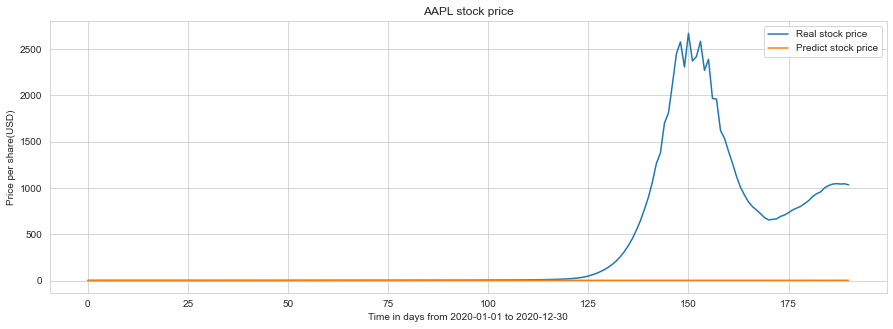

Train Score: 3.10 RMSE
Test Score: 28759.67 RMSE
MAE: 373.9695825157819 and MSE: 576888.5989063911 and MAPE: 82.62091697844848
[*********************100%***********************]  1 of 1 completed
X shape: (947, 60, 1) 
y shape: (947,)
X shape: (192, 60, 1) 
y shape: (192,)
X shape: (191, 60, 1) 
y shape: (191,)

Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
activation        |selu              |?                 
recurrent_dropout |0.48482           |?                 
num_units         |47                |?                 
learning_rate     |8.9174e-08        |?                 

Epoch 1/100
24/24 [==============================] - 3s 34ms/step - loss: 0.2969 - mean_absolute_error: 0.4540 - val_loss: 1.6908 - val_mean_absolute_error: 1.2954
Epoch 2/100
24/24 [==============================] - 1s 21ms/step - loss: 0.3030 - mean_absolute_error: 0.4533 - val_loss: 1.6890 - val_mean_absolute_error: 1.2947
Epoch 3/100
24/24 [===========================

Epoch 42/100
24/24 [==============================] - 1s 28ms/step - loss: 0.2621 - mean_absolute_error: 0.4100 - val_loss: 1.6174 - val_mean_absolute_error: 1.2667
Epoch 43/100
24/24 [==============================] - 1s 22ms/step - loss: 0.2682 - mean_absolute_error: 0.4190 - val_loss: 1.6156 - val_mean_absolute_error: 1.2660
Epoch 44/100
24/24 [==============================] - 1s 22ms/step - loss: 0.2769 - mean_absolute_error: 0.4282 - val_loss: 1.6138 - val_mean_absolute_error: 1.2653
Epoch 45/100
24/24 [==============================] - 1s 22ms/step - loss: 0.2739 - mean_absolute_error: 0.4195 - val_loss: 1.6121 - val_mean_absolute_error: 1.2646
Epoch 46/100
24/24 [==============================] - 1s 22ms/step - loss: 0.2701 - mean_absolute_error: 0.4157 - val_loss: 1.6103 - val_mean_absolute_error: 1.2639
Epoch 47/100
24/24 [==============================] - 1s 23ms/step - loss: 0.2779 - mean_absolute_error: 0.4331 - val_loss: 1.6086 - val_mean_absolute_error: 1.2632
Epoch 48/1

Epoch 92/100
24/24 [==============================] - 1s 24ms/step - loss: 0.2326 - mean_absolute_error: 0.3864 - val_loss: 1.5303 - val_mean_absolute_error: 1.2318
Epoch 93/100
24/24 [==============================] - 1s 26ms/step - loss: 0.2345 - mean_absolute_error: 0.3866 - val_loss: 1.5286 - val_mean_absolute_error: 1.2312
Epoch 94/100
24/24 [==============================] - 1s 28ms/step - loss: 0.2423 - mean_absolute_error: 0.3956 - val_loss: 1.5269 - val_mean_absolute_error: 1.2305
Epoch 95/100
24/24 [==============================] - 1s 26ms/step - loss: 0.2486 - mean_absolute_error: 0.3984 - val_loss: 1.5252 - val_mean_absolute_error: 1.2298
Epoch 96/100
24/24 [==============================] - 1s 25ms/step - loss: 0.2393 - mean_absolute_error: 0.3948 - val_loss: 1.5234 - val_mean_absolute_error: 1.2291
Epoch 97/100
24/24 [==============================] - 1s 26ms/step - loss: 0.2655 - mean_absolute_error: 0.4205 - val_loss: 1.5217 - val_mean_absolute_error: 1.2283
Epoch 98/1

Epoch 39/100
24/24 [==============================] - 1s 27ms/step - loss: 0.0276 - mean_absolute_error: 0.1248 - val_loss: 0.2035 - val_mean_absolute_error: 0.4476
Epoch 40/100
24/24 [==============================] - 1s 26ms/step - loss: 0.0256 - mean_absolute_error: 0.1212 - val_loss: 0.1965 - val_mean_absolute_error: 0.4398
Epoch 41/100
24/24 [==============================] - 1s 24ms/step - loss: 0.0264 - mean_absolute_error: 0.1196 - val_loss: 0.1897 - val_mean_absolute_error: 0.4321
Epoch 42/100
24/24 [==============================] - 1s 24ms/step - loss: 0.0256 - mean_absolute_error: 0.1183 - val_loss: 0.1829 - val_mean_absolute_error: 0.4242
Epoch 43/100
24/24 [==============================] - 1s 24ms/step - loss: 0.0230 - mean_absolute_error: 0.1123 - val_loss: 0.1761 - val_mean_absolute_error: 0.4162
Epoch 44/100
24/24 [==============================] - 1s 25ms/step - loss: 0.0218 - mean_absolute_error: 0.1094 - val_loss: 0.1697 - val_mean_absolute_error: 0.4084
Epoch 45/1

Epoch 89/100
24/24 [==============================] - 1s 24ms/step - loss: 0.0051 - mean_absolute_error: 0.0551 - val_loss: 0.0172 - val_mean_absolute_error: 0.1256
Epoch 90/100
24/24 [==============================] - 1s 27ms/step - loss: 0.0053 - mean_absolute_error: 0.0580 - val_loss: 0.0164 - val_mean_absolute_error: 0.1228
Epoch 91/100
24/24 [==============================] - 1s 24ms/step - loss: 0.0048 - mean_absolute_error: 0.0543 - val_loss: 0.0159 - val_mean_absolute_error: 0.1205
Epoch 92/100
24/24 [==============================] - 1s 26ms/step - loss: 0.0049 - mean_absolute_error: 0.0556 - val_loss: 0.0154 - val_mean_absolute_error: 0.1188
Epoch 93/100
24/24 [==============================] - 1s 25ms/step - loss: 0.0054 - mean_absolute_error: 0.0565 - val_loss: 0.0147 - val_mean_absolute_error: 0.1158
Epoch 94/100
24/24 [==============================] - 1s 27ms/step - loss: 0.0053 - mean_absolute_error: 0.0564 - val_loss: 0.0145 - val_mean_absolute_error: 0.1148
Epoch 95/1

Epoch 36/100
24/24 [==============================] - 1s 23ms/step - loss: 0.0589 - mean_absolute_error: 0.2015 - val_loss: 0.3861 - val_mean_absolute_error: 0.6179
Epoch 37/100
24/24 [==============================] - 1s 24ms/step - loss: 0.0576 - mean_absolute_error: 0.2001 - val_loss: 0.3860 - val_mean_absolute_error: 0.6179
Epoch 38/100
24/24 [==============================] - 1s 24ms/step - loss: 0.0606 - mean_absolute_error: 0.2029 - val_loss: 0.3860 - val_mean_absolute_error: 0.6179
Epoch 39/100
24/24 [==============================] - 1s 23ms/step - loss: 0.0573 - mean_absolute_error: 0.1981 - val_loss: 0.3860 - val_mean_absolute_error: 0.6179
Epoch 40/100
24/24 [==============================] - 1s 23ms/step - loss: 0.0567 - mean_absolute_error: 0.1977 - val_loss: 0.3859 - val_mean_absolute_error: 0.6178
Epoch 41/100
24/24 [==============================] - 1s 22ms/step - loss: 0.0591 - mean_absolute_error: 0.2026 - val_loss: 0.3859 - val_mean_absolute_error: 0.6178
Epoch 42/1

Epoch 86/100
24/24 [==============================] - 1s 25ms/step - loss: 0.0582 - mean_absolute_error: 0.2005 - val_loss: 0.3843 - val_mean_absolute_error: 0.6166
Epoch 87/100
24/24 [==============================] - 1s 27ms/step - loss: 0.0611 - mean_absolute_error: 0.2078 - val_loss: 0.3843 - val_mean_absolute_error: 0.6165
Epoch 88/100
24/24 [==============================] - 1s 24ms/step - loss: 0.0552 - mean_absolute_error: 0.1948 - val_loss: 0.3843 - val_mean_absolute_error: 0.6165
Epoch 89/100
24/24 [==============================] - 1s 23ms/step - loss: 0.0609 - mean_absolute_error: 0.2050 - val_loss: 0.3842 - val_mean_absolute_error: 0.6165
Epoch 90/100
24/24 [==============================] - 1s 24ms/step - loss: 0.0604 - mean_absolute_error: 0.2062 - val_loss: 0.3842 - val_mean_absolute_error: 0.6164
Epoch 91/100
24/24 [==============================] - 1s 24ms/step - loss: 0.0555 - mean_absolute_error: 0.1976 - val_loss: 0.3842 - val_mean_absolute_error: 0.6164
Epoch 92/1

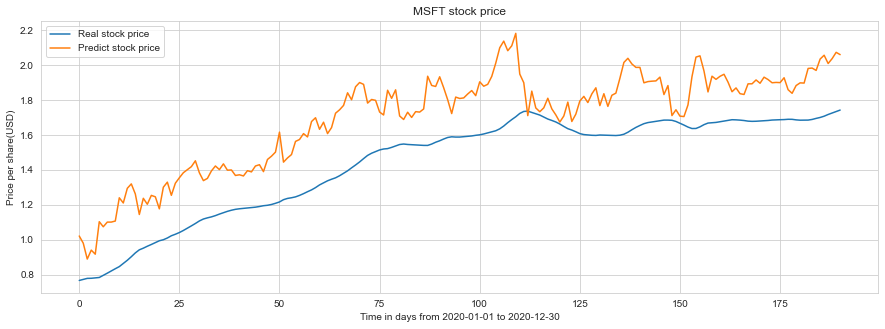

Train Score: 4.07 RMSE
Test Score: 16.82 RMSE
MAE: 0.254781226298179 and MSE: 0.07468983811715002 and MAPE: 31.8925580401615
[*********************100%***********************]  1 of 1 completed
X shape: (947, 60, 1) 
y shape: (947,)
X shape: (192, 60, 1) 
y shape: (192,)
X shape: (191, 60, 1) 
y shape: (191,)

Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
activation        |linear            |?                 
recurrent_dropout |0.047993          |?                 
num_units         |35                |?                 
learning_rate     |4.297e-06         |?                 

Epoch 1/100
24/24 [==============================] - 3s 33ms/step - loss: 0.0948 - mean_absolute_error: 0.2714 - val_loss: 0.5814 - val_mean_absolute_error: 0.7571
Epoch 2/100
24/24 [==============================] - 1s 23ms/step - loss: 0.0936 - mean_absolute_error: 0.2682 - val_loss: 0.5752 - val_mean_absolute_error: 0.7530
Epoch 3/100
24/24 [=============================

Epoch 42/100
24/24 [==============================] - 1s 23ms/step - loss: 0.0531 - mean_absolute_error: 0.1934 - val_loss: 0.3422 - val_mean_absolute_error: 0.5801
Epoch 43/100
24/24 [==============================] - 1s 24ms/step - loss: 0.0499 - mean_absolute_error: 0.1878 - val_loss: 0.3366 - val_mean_absolute_error: 0.5753
Epoch 44/100
24/24 [==============================] - 1s 25ms/step - loss: 0.0497 - mean_absolute_error: 0.1883 - val_loss: 0.3311 - val_mean_absolute_error: 0.5706
Epoch 45/100
24/24 [==============================] - 1s 24ms/step - loss: 0.0487 - mean_absolute_error: 0.1875 - val_loss: 0.3256 - val_mean_absolute_error: 0.5657
Epoch 46/100
24/24 [==============================] - 1s 23ms/step - loss: 0.0485 - mean_absolute_error: 0.1847 - val_loss: 0.3201 - val_mean_absolute_error: 0.5609
Epoch 47/100
24/24 [==============================] - 1s 23ms/step - loss: 0.0461 - mean_absolute_error: 0.1810 - val_loss: 0.3145 - val_mean_absolute_error: 0.5560
Epoch 48/1

Epoch 92/100
24/24 [==============================] - 1s 23ms/step - loss: 0.0107 - mean_absolute_error: 0.0813 - val_loss: 0.0870 - val_mean_absolute_error: 0.2902
Epoch 93/100
24/24 [==============================] - 1s 23ms/step - loss: 0.0099 - mean_absolute_error: 0.0771 - val_loss: 0.0828 - val_mean_absolute_error: 0.2829
Epoch 94/100
24/24 [==============================] - 1s 22ms/step - loss: 0.0112 - mean_absolute_error: 0.0812 - val_loss: 0.0787 - val_mean_absolute_error: 0.2756
Epoch 95/100
24/24 [==============================] - 1s 26ms/step - loss: 0.0101 - mean_absolute_error: 0.0773 - val_loss: 0.0748 - val_mean_absolute_error: 0.2685
Epoch 96/100
24/24 [==============================] - 1s 25ms/step - loss: 0.0093 - mean_absolute_error: 0.0735 - val_loss: 0.0709 - val_mean_absolute_error: 0.2612
Epoch 97/100
24/24 [==============================] - 1s 23ms/step - loss: 0.0089 - mean_absolute_error: 0.0718 - val_loss: 0.0670 - val_mean_absolute_error: 0.2539
Epoch 98/1

Epoch 39/100
24/24 [==============================] - 1s 23ms/step - loss: 0.0888 - mean_absolute_error: 0.2537 - val_loss: 0.5569 - val_mean_absolute_error: 0.7403
Epoch 40/100
24/24 [==============================] - 1s 22ms/step - loss: 0.0774 - mean_absolute_error: 0.2372 - val_loss: 0.5473 - val_mean_absolute_error: 0.7338
Epoch 41/100
24/24 [==============================] - 1s 27ms/step - loss: 0.0774 - mean_absolute_error: 0.2353 - val_loss: 0.5376 - val_mean_absolute_error: 0.7272
Epoch 42/100
24/24 [==============================] - 1s 23ms/step - loss: 0.0702 - mean_absolute_error: 0.2202 - val_loss: 0.5279 - val_mean_absolute_error: 0.7206
Epoch 43/100
24/24 [==============================] - 1s 22ms/step - loss: 0.0755 - mean_absolute_error: 0.2334 - val_loss: 0.5181 - val_mean_absolute_error: 0.7138
Epoch 44/100
24/24 [==============================] - 1s 22ms/step - loss: 0.0773 - mean_absolute_error: 0.2337 - val_loss: 0.5084 - val_mean_absolute_error: 0.7070
Epoch 45/1

Epoch 89/100
24/24 [==============================] - 1s 25ms/step - loss: 0.0182 - mean_absolute_error: 0.1007 - val_loss: 0.1725 - val_mean_absolute_error: 0.4078
Epoch 90/100
24/24 [==============================] - 1s 25ms/step - loss: 0.0165 - mean_absolute_error: 0.0969 - val_loss: 0.1676 - val_mean_absolute_error: 0.4018
Epoch 91/100
24/24 [==============================] - 1s 23ms/step - loss: 0.0173 - mean_absolute_error: 0.0989 - val_loss: 0.1627 - val_mean_absolute_error: 0.3957
Epoch 92/100
24/24 [==============================] - 1s 21ms/step - loss: 0.0155 - mean_absolute_error: 0.0954 - val_loss: 0.1581 - val_mean_absolute_error: 0.3900
Epoch 93/100
24/24 [==============================] - 0s 21ms/step - loss: 0.0138 - mean_absolute_error: 0.0888 - val_loss: 0.1536 - val_mean_absolute_error: 0.3841
Epoch 94/100
24/24 [==============================] - 0s 20ms/step - loss: 0.0150 - mean_absolute_error: 0.0930 - val_loss: 0.1491 - val_mean_absolute_error: 0.3784
Epoch 95/1

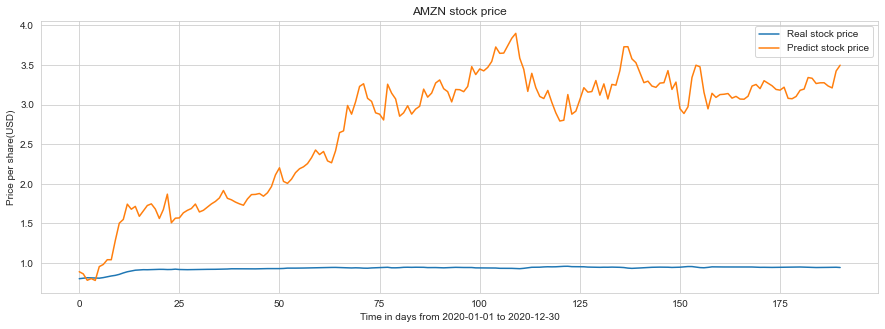

Train Score: 106.82 RMSE
Test Score: 1000.87 RMSE
MAE: 1.7738614470651572 and MSE: 3.694574677223795 and MAPE: 191.15757592546478
[*********************100%***********************]  1 of 1 completed
X shape: (947, 60, 1) 
y shape: (947,)
X shape: (192, 60, 1) 
y shape: (192,)
X shape: (191, 60, 1) 
y shape: (191,)

Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
activation        |selu              |?                 
recurrent_dropout |0.0029528         |?                 
num_units         |53                |?                 
learning_rate     |4.3498e-06        |?                 

Epoch 1/100
24/24 [==============================] - 3s 41ms/step - loss: 0.2540 - mean_absolute_error: 0.4354 - val_loss: 0.5684 - val_mean_absolute_error: 0.7334
Epoch 2/100
24/24 [==============================] - 1s 24ms/step - loss: 0.2227 - mean_absolute_error: 0.4040 - val_loss: 0.5431 - val_mean_absolute_error: 0.7164
Epoch 3/100
24/24 [========================

Epoch 42/100
24/24 [==============================] - 1s 25ms/step - loss: 0.0088 - mean_absolute_error: 0.0732 - val_loss: 0.0239 - val_mean_absolute_error: 0.1190
Epoch 43/100
24/24 [==============================] - 1s 24ms/step - loss: 0.0082 - mean_absolute_error: 0.0716 - val_loss: 0.0215 - val_mean_absolute_error: 0.1113
Epoch 44/100
24/24 [==============================] - 1s 25ms/step - loss: 0.0062 - mean_absolute_error: 0.0617 - val_loss: 0.0195 - val_mean_absolute_error: 0.1047
Epoch 45/100
24/24 [==============================] - 1s 25ms/step - loss: 0.0057 - mean_absolute_error: 0.0607 - val_loss: 0.0177 - val_mean_absolute_error: 0.0994
Epoch 46/100
24/24 [==============================] - 1s 25ms/step - loss: 0.0054 - mean_absolute_error: 0.0581 - val_loss: 0.0162 - val_mean_absolute_error: 0.0952
Epoch 47/100
24/24 [==============================] - 1s 28ms/step - loss: 0.0050 - mean_absolute_error: 0.0565 - val_loss: 0.0149 - val_mean_absolute_error: 0.0919
Epoch 48/1

Epoch 13/100
24/24 [==============================] - 1s 23ms/step - loss: 0.1804 - mean_absolute_error: 0.3682 - val_loss: 0.4267 - val_mean_absolute_error: 0.6364
Epoch 14/100
24/24 [==============================] - 1s 23ms/step - loss: 0.1809 - mean_absolute_error: 0.3700 - val_loss: 0.4267 - val_mean_absolute_error: 0.6364
Epoch 15/100
24/24 [==============================] - 1s 23ms/step - loss: 0.1924 - mean_absolute_error: 0.3810 - val_loss: 0.4267 - val_mean_absolute_error: 0.6364
Epoch 16/100
24/24 [==============================] - 1s 23ms/step - loss: 0.1873 - mean_absolute_error: 0.3735 - val_loss: 0.4267 - val_mean_absolute_error: 0.6363
Epoch 17/100
24/24 [==============================] - 1s 23ms/step - loss: 0.1808 - mean_absolute_error: 0.3711 - val_loss: 0.4266 - val_mean_absolute_error: 0.6363
Epoch 18/100
24/24 [==============================] - 1s 23ms/step - loss: 0.1889 - mean_absolute_error: 0.3769 - val_loss: 0.4266 - val_mean_absolute_error: 0.6363
Epoch 19/1

Epoch 63/100
24/24 [==============================] - 1s 28ms/step - loss: 0.1848 - mean_absolute_error: 0.3720 - val_loss: 0.4259 - val_mean_absolute_error: 0.6358
Epoch 64/100
24/24 [==============================] - 1s 26ms/step - loss: 0.1820 - mean_absolute_error: 0.3685 - val_loss: 0.4259 - val_mean_absolute_error: 0.6358
Epoch 65/100
24/24 [==============================] - 1s 27ms/step - loss: 0.1841 - mean_absolute_error: 0.3696 - val_loss: 0.4259 - val_mean_absolute_error: 0.6358
Epoch 66/100
24/24 [==============================] - 1s 26ms/step - loss: 0.1919 - mean_absolute_error: 0.3807 - val_loss: 0.4259 - val_mean_absolute_error: 0.6357
Epoch 67/100
24/24 [==============================] - 1s 26ms/step - loss: 0.1822 - mean_absolute_error: 0.3701 - val_loss: 0.4258 - val_mean_absolute_error: 0.6357
Epoch 68/100
24/24 [==============================] - 1s 26ms/step - loss: 0.1767 - mean_absolute_error: 0.3603 - val_loss: 0.4258 - val_mean_absolute_error: 0.6357
Epoch 69/1

Epoch 10/100
24/24 [==============================] - 1s 28ms/step - loss: 0.1451 - mean_absolute_error: 0.3301 - val_loss: 0.3418 - val_mean_absolute_error: 0.5694
Epoch 11/100
24/24 [==============================] - 1s 29ms/step - loss: 0.1471 - mean_absolute_error: 0.3316 - val_loss: 0.3418 - val_mean_absolute_error: 0.5694
Epoch 12/100
24/24 [==============================] - 1s 29ms/step - loss: 0.1521 - mean_absolute_error: 0.3355 - val_loss: 0.3418 - val_mean_absolute_error: 0.5694
Epoch 13/100
24/24 [==============================] - 1s 29ms/step - loss: 0.1427 - mean_absolute_error: 0.3255 - val_loss: 0.3417 - val_mean_absolute_error: 0.5693
Epoch 14/100
24/24 [==============================] - 1s 30ms/step - loss: 0.1457 - mean_absolute_error: 0.3338 - val_loss: 0.3417 - val_mean_absolute_error: 0.5693
Epoch 15/100
24/24 [==============================] - 1s 28ms/step - loss: 0.1476 - mean_absolute_error: 0.3329 - val_loss: 0.3416 - val_mean_absolute_error: 0.5693
Epoch 16/1

Epoch 60/100
24/24 [==============================] - 1s 26ms/step - loss: 0.1457 - mean_absolute_error: 0.3277 - val_loss: 0.3400 - val_mean_absolute_error: 0.5679
Epoch 61/100
24/24 [==============================] - 1s 26ms/step - loss: 0.1446 - mean_absolute_error: 0.3283 - val_loss: 0.3399 - val_mean_absolute_error: 0.5678
Epoch 62/100
24/24 [==============================] - 1s 26ms/step - loss: 0.1400 - mean_absolute_error: 0.3230 - val_loss: 0.3399 - val_mean_absolute_error: 0.5678
Epoch 63/100
24/24 [==============================] - 1s 27ms/step - loss: 0.1472 - mean_absolute_error: 0.3337 - val_loss: 0.3399 - val_mean_absolute_error: 0.5678
Epoch 64/100
24/24 [==============================] - 1s 26ms/step - loss: 0.1424 - mean_absolute_error: 0.3259 - val_loss: 0.3398 - val_mean_absolute_error: 0.5677
Epoch 65/100
24/24 [==============================] - 1s 26ms/step - loss: 0.1438 - mean_absolute_error: 0.3270 - val_loss: 0.3398 - val_mean_absolute_error: 0.5677
Epoch 66/1

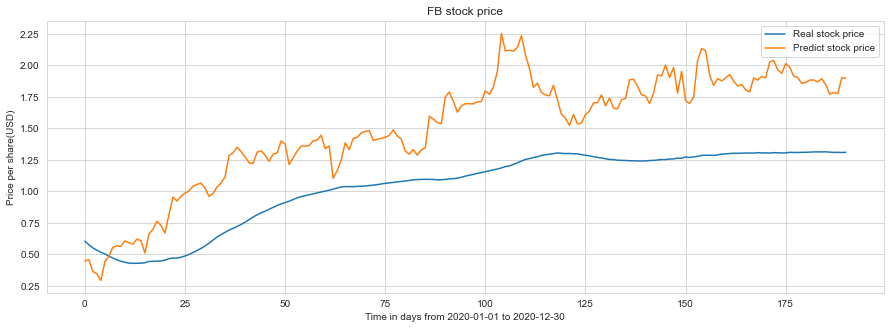

Train Score: 4.25 RMSE
Test Score: 38.64 RMSE
MAE: 0.46954487664510414 and MSE: 0.25604900811503223 and MAPE: 75.46012847556071
[*********************100%***********************]  1 of 1 completed
X shape: (947, 60, 1) 
y shape: (947,)
X shape: (192, 60, 1) 
y shape: (192,)
X shape: (191, 60, 1) 
y shape: (191,)

Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
activation        |relu              |?                 
recurrent_dropout |0.18663           |?                 
num_units         |47                |?                 
learning_rate     |4.0904e-05        |?                 

Epoch 1/100
24/24 [==============================] - 3s 38ms/step - loss: 0.1871 - mean_absolute_error: 0.3906 - val_loss: 0.5541 - val_mean_absolute_error: 0.7391
Epoch 2/100
24/24 [==============================] - 1s 25ms/step - loss: 0.1722 - mean_absolute_error: 0.3714 - val_loss: 0.5312 - val_mean_absolute_error: 0.7236
Epoch 3/100
24/24 [==========================

24/24 [==============================] - 1s 26ms/step - loss: 0.1680 - mean_absolute_error: 0.3682 - val_loss: 0.5412 - val_mean_absolute_error: 0.7304
Epoch 40/100
24/24 [==============================] - 1s 26ms/step - loss: 0.1749 - mean_absolute_error: 0.3734 - val_loss: 0.5412 - val_mean_absolute_error: 0.7304
Epoch 41/100
24/24 [==============================] - 1s 32ms/step - loss: 0.1776 - mean_absolute_error: 0.3786 - val_loss: 0.5411 - val_mean_absolute_error: 0.7304
Epoch 42/100
24/24 [==============================] - 1s 31ms/step - loss: 0.1732 - mean_absolute_error: 0.3755 - val_loss: 0.5411 - val_mean_absolute_error: 0.7304
Epoch 43/100
24/24 [==============================] - 1s 28ms/step - loss: 0.1782 - mean_absolute_error: 0.3784 - val_loss: 0.5411 - val_mean_absolute_error: 0.7303
Epoch 44/100
24/24 [==============================] - 1s 32ms/step - loss: 0.1691 - mean_absolute_error: 0.3696 - val_loss: 0.5410 - val_mean_absolute_error: 0.7303
Epoch 45/100
24/24 [===

Epoch 89/100
24/24 [==============================] - 1s 26ms/step - loss: 0.1727 - mean_absolute_error: 0.3724 - val_loss: 0.5395 - val_mean_absolute_error: 0.7292
Epoch 90/100
24/24 [==============================] - 1s 26ms/step - loss: 0.1760 - mean_absolute_error: 0.3755 - val_loss: 0.5394 - val_mean_absolute_error: 0.7292
Epoch 91/100
24/24 [==============================] - 1s 26ms/step - loss: 0.1655 - mean_absolute_error: 0.3664 - val_loss: 0.5394 - val_mean_absolute_error: 0.7292
Epoch 92/100
24/24 [==============================] - 1s 32ms/step - loss: 0.1787 - mean_absolute_error: 0.3791 - val_loss: 0.5394 - val_mean_absolute_error: 0.7292
Epoch 93/100
24/24 [==============================] - 1s 32ms/step - loss: 0.1763 - mean_absolute_error: 0.3760 - val_loss: 0.5393 - val_mean_absolute_error: 0.7292
Epoch 94/100
24/24 [==============================] - 1s 28ms/step - loss: 0.1771 - mean_absolute_error: 0.3790 - val_loss: 0.5393 - val_mean_absolute_error: 0.7291
Epoch 95/1

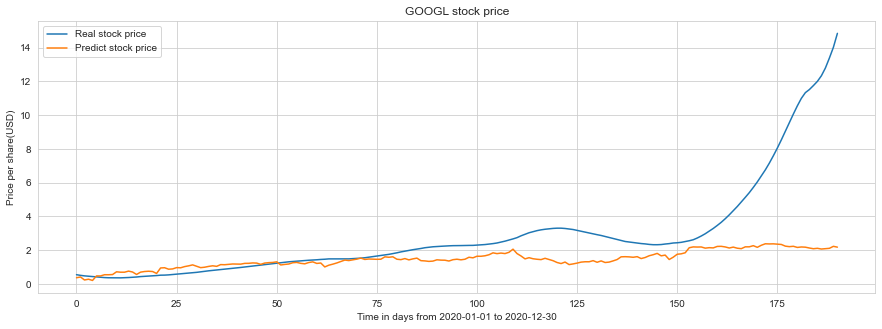

Train Score: 23.37 RMSE
Test Score: 993.47 RMSE
MAE: 1.5223440889394184 and MSE: 8.690536410630854 and MAPE: 77.73827985245386
[*********************100%***********************]  1 of 1 completed
X shape: (947, 60, 1) 
y shape: (947,)
X shape: (192, 60, 1) 
y shape: (192,)
X shape: (191, 60, 1) 
y shape: (191,)

Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
activation        |selu              |?                 
recurrent_dropout |0.098267          |?                 
num_units         |16                |?                 
learning_rate     |1.3698e-10        |?                 

Epoch 1/100
24/24 [==============================] - 3s 38ms/step - loss: 0.1925 - mean_absolute_error: 0.3824 - val_loss: 0.6817 - val_mean_absolute_error: 0.8194
Epoch 2/100
24/24 [==============================] - 1s 23ms/step - loss: 0.1953 - mean_absolute_error: 0.3772 - val_loss: 0.6817 - val_mean_absolute_error: 0.8194
Epoch 3/100
24/24 [===========================

Epoch 42/100
24/24 [==============================] - 1s 25ms/step - loss: 0.1882 - mean_absolute_error: 0.3708 - val_loss: 0.6817 - val_mean_absolute_error: 0.8194
Epoch 43/100
24/24 [==============================] - 1s 23ms/step - loss: 0.1896 - mean_absolute_error: 0.3751 - val_loss: 0.6817 - val_mean_absolute_error: 0.8194
Epoch 44/100
24/24 [==============================] - 1s 28ms/step - loss: 0.1949 - mean_absolute_error: 0.3770 - val_loss: 0.6817 - val_mean_absolute_error: 0.8194
Epoch 45/100
24/24 [==============================] - 1s 29ms/step - loss: 0.1851 - mean_absolute_error: 0.3681 - val_loss: 0.6817 - val_mean_absolute_error: 0.8194
Epoch 46/100
24/24 [==============================] - 1s 26ms/step - loss: 0.1920 - mean_absolute_error: 0.3768 - val_loss: 0.6817 - val_mean_absolute_error: 0.8194
Epoch 47/100
24/24 [==============================] - 1s 27ms/step - loss: 0.1745 - mean_absolute_error: 0.3552 - val_loss: 0.6817 - val_mean_absolute_error: 0.8194
Epoch 48/1

Epoch 92/100
24/24 [==============================] - 1s 22ms/step - loss: 0.1863 - mean_absolute_error: 0.3719 - val_loss: 0.6817 - val_mean_absolute_error: 0.8194
Epoch 93/100
24/24 [==============================] - 1s 22ms/step - loss: 0.1918 - mean_absolute_error: 0.3788 - val_loss: 0.6817 - val_mean_absolute_error: 0.8194
Epoch 94/100
24/24 [==============================] - 1s 25ms/step - loss: 0.1864 - mean_absolute_error: 0.3697 - val_loss: 0.6817 - val_mean_absolute_error: 0.8194
Epoch 95/100
24/24 [==============================] - 1s 24ms/step - loss: 0.1747 - mean_absolute_error: 0.3596 - val_loss: 0.6817 - val_mean_absolute_error: 0.8194
Epoch 96/100
24/24 [==============================] - 1s 24ms/step - loss: 0.1889 - mean_absolute_error: 0.3752 - val_loss: 0.6817 - val_mean_absolute_error: 0.8194
Epoch 97/100
24/24 [==============================] - 1s 23ms/step - loss: 0.1844 - mean_absolute_error: 0.3728 - val_loss: 0.6817 - val_mean_absolute_error: 0.8194
Epoch 98/1

Epoch 86/100
24/24 [==============================] - 1s 23ms/step - loss: 4.9526e-04 - mean_absolute_error: 0.0158 - val_loss: 8.0347e-04 - val_mean_absolute_error: 0.0220
Epoch 87/100
24/24 [==============================] - 1s 22ms/step - loss: 4.2305e-04 - mean_absolute_error: 0.0143 - val_loss: 8.6361e-04 - val_mean_absolute_error: 0.0234
Epoch 88/100
24/24 [==============================] - 1s 22ms/step - loss: 4.1856e-04 - mean_absolute_error: 0.0146 - val_loss: 8.1333e-04 - val_mean_absolute_error: 0.0224
Epoch 89/100
24/24 [==============================] - 1s 23ms/step - loss: 4.0703e-04 - mean_absolute_error: 0.0146 - val_loss: 8.1297e-04 - val_mean_absolute_error: 0.0219
Epoch 90/100
24/24 [==============================] - 1s 22ms/step - loss: 4.8944e-04 - mean_absolute_error: 0.0149 - val_loss: 8.1080e-04 - val_mean_absolute_error: 0.0219
Epoch 91/100
24/24 [==============================] - 1s 23ms/step - loss: 4.5211e-04 - mean_absolute_error: 0.0148 - val_loss: 8.0425e

Epoch 42/100
24/24 [==============================] - 1s 22ms/step - loss: 0.0015 - mean_absolute_error: 0.0298 - val_loss: 0.0048 - val_mean_absolute_error: 0.0626
Epoch 43/100
24/24 [==============================] - 0s 21ms/step - loss: 0.0015 - mean_absolute_error: 0.0295 - val_loss: 0.0046 - val_mean_absolute_error: 0.0607
Epoch 44/100
24/24 [==============================] - 1s 23ms/step - loss: 0.0015 - mean_absolute_error: 0.0283 - val_loss: 0.0041 - val_mean_absolute_error: 0.0567
Epoch 45/100
24/24 [==============================] - 1s 23ms/step - loss: 0.0013 - mean_absolute_error: 0.0264 - val_loss: 0.0043 - val_mean_absolute_error: 0.0588
Epoch 46/100
24/24 [==============================] - 1s 22ms/step - loss: 0.0015 - mean_absolute_error: 0.0285 - val_loss: 0.0040 - val_mean_absolute_error: 0.0564
Epoch 47/100
24/24 [==============================] - 1s 21ms/step - loss: 0.0012 - mean_absolute_error: 0.0257 - val_loss: 0.0044 - val_mean_absolute_error: 0.0593
Epoch 48/1

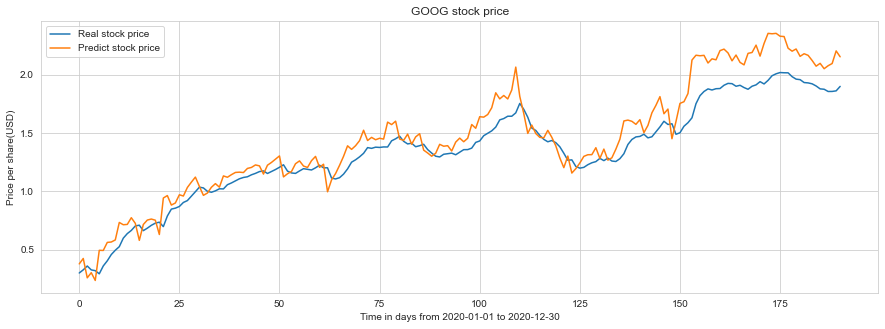

Train Score: 7.63 RMSE
Test Score: 57.63 RMSE
MAE: 0.13405958374581858 and MSE: 0.027888259366085286 and MAPE: 53.42761142423136
[*********************100%***********************]  1 of 1 completed
X shape: (947, 60, 1) 
y shape: (947,)
X shape: (192, 60, 1) 
y shape: (192,)
X shape: (191, 60, 1) 
y shape: (191,)

Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
activation        |selu              |?                 
recurrent_dropout |0.66302           |?                 
num_units         |11                |?                 
learning_rate     |2.1941e-10        |?                 

Epoch 1/100
24/24 [==============================] - 3s 34ms/step - loss: 0.0207 - mean_absolute_error: 0.1100 - val_loss: 0.0045 - val_mean_absolute_error: 0.0577
Epoch 2/100
24/24 [==============================] - 1s 22ms/step - loss: 0.0210 - mean_absolute_error: 0.1125 - val_loss: 0.0045 - val_mean_absolute_error: 0.0577
Epoch 3/100
24/24 [=========================

Epoch 83/100
24/24 [==============================] - 1s 26ms/step - loss: 0.2007 - mean_absolute_error: 0.3676 - val_loss: 0.6239 - val_mean_absolute_error: 0.7866
Epoch 84/100
24/24 [==============================] - 1s 26ms/step - loss: 0.1848 - mean_absolute_error: 0.3548 - val_loss: 0.6239 - val_mean_absolute_error: 0.7866
Epoch 85/100
24/24 [==============================] - 1s 26ms/step - loss: 0.1898 - mean_absolute_error: 0.3602 - val_loss: 0.6239 - val_mean_absolute_error: 0.7866
Epoch 86/100
24/24 [==============================] - 1s 30ms/step - loss: 0.1969 - mean_absolute_error: 0.3700 - val_loss: 0.6239 - val_mean_absolute_error: 0.7866
Epoch 87/100
24/24 [==============================] - 1s 27ms/step - loss: 0.1849 - mean_absolute_error: 0.3555 - val_loss: 0.6239 - val_mean_absolute_error: 0.7866
Epoch 88/100
24/24 [==============================] - 1s 27ms/step - loss: 0.2041 - mean_absolute_error: 0.3750 - val_loss: 0.6239 - val_mean_absolute_error: 0.7866
Epoch 89/1

Epoch 30/100
24/24 [==============================] - 0s 20ms/step - loss: 0.0667 - mean_absolute_error: 0.1858 - val_loss: 0.2570 - val_mean_absolute_error: 0.5032
Epoch 31/100
24/24 [==============================] - 0s 20ms/step - loss: 0.0649 - mean_absolute_error: 0.1798 - val_loss: 0.2436 - val_mean_absolute_error: 0.4897
Epoch 32/100
24/24 [==============================] - 0s 20ms/step - loss: 0.0500 - mean_absolute_error: 0.1605 - val_loss: 0.2306 - val_mean_absolute_error: 0.4763
Epoch 33/100
24/24 [==============================] - 0s 20ms/step - loss: 0.0577 - mean_absolute_error: 0.1699 - val_loss: 0.2168 - val_mean_absolute_error: 0.4617
Epoch 34/100
24/24 [==============================] - 0s 21ms/step - loss: 0.0538 - mean_absolute_error: 0.1673 - val_loss: 0.2041 - val_mean_absolute_error: 0.4478
Epoch 35/100
24/24 [==============================] - 0s 21ms/step - loss: 0.0524 - mean_absolute_error: 0.1630 - val_loss: 0.1914 - val_mean_absolute_error: 0.4335
Epoch 36/1

Epoch 80/100
24/24 [==============================] - 0s 20ms/step - loss: 0.0095 - mean_absolute_error: 0.0807 - val_loss: 0.0034 - val_mean_absolute_error: 0.0494
Epoch 81/100
24/24 [==============================] - 0s 20ms/step - loss: 0.0079 - mean_absolute_error: 0.0746 - val_loss: 0.0031 - val_mean_absolute_error: 0.0466
Epoch 82/100
24/24 [==============================] - 0s 20ms/step - loss: 0.0085 - mean_absolute_error: 0.0756 - val_loss: 0.0028 - val_mean_absolute_error: 0.0444
Epoch 83/100
24/24 [==============================] - 1s 22ms/step - loss: 0.0077 - mean_absolute_error: 0.0704 - val_loss: 0.0026 - val_mean_absolute_error: 0.0422
Epoch 84/100
24/24 [==============================] - 1s 21ms/step - loss: 0.0078 - mean_absolute_error: 0.0742 - val_loss: 0.0024 - val_mean_absolute_error: 0.0402
Epoch 85/100
24/24 [==============================] - 1s 21ms/step - loss: 0.0081 - mean_absolute_error: 0.0731 - val_loss: 0.0023 - val_mean_absolute_error: 0.0385
Epoch 86/1

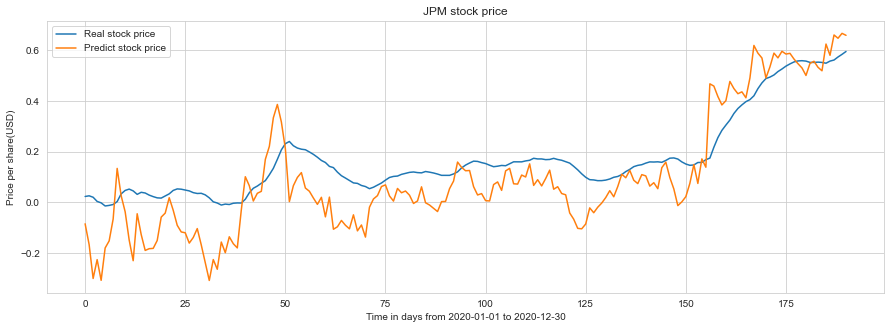

Train Score: 2.17 RMSE
Test Score: 5.56 RMSE
MAE: 0.10936125406788763 and MSE: 0.01728818338421919 and MAPE: 521.171958985621
[*********************100%***********************]  1 of 1 completed
X shape: (947, 60, 1) 
y shape: (947,)
X shape: (192, 60, 1) 
y shape: (192,)
X shape: (191, 60, 1) 
y shape: (191,)

Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
activation        |linear            |?                 
recurrent_dropout |0.10386           |?                 
num_units         |8                 |?                 
learning_rate     |0.00018872        |?                 

Epoch 1/100
24/24 [==============================] - 3s 37ms/step - loss: 0.1027 - mean_absolute_error: 0.2768 - val_loss: 0.1677 - val_mean_absolute_error: 0.3987
Epoch 2/100
24/24 [==============================] - 1s 21ms/step - loss: 0.0720 - mean_absolute_error: 0.2276 - val_loss: 0.1132 - val_mean_absolute_error: 0.3250
Epoch 3/100
24/24 [============================

Epoch 68/100
24/24 [==============================] - 0s 21ms/step - loss: 0.0061 - mean_absolute_error: 0.0607 - val_loss: 0.0046 - val_mean_absolute_error: 0.0489
Epoch 69/100
24/24 [==============================] - 1s 21ms/step - loss: 0.0063 - mean_absolute_error: 0.0635 - val_loss: 0.0047 - val_mean_absolute_error: 0.0502
Epoch 70/100
24/24 [==============================] - 1s 21ms/step - loss: 0.0054 - mean_absolute_error: 0.0574 - val_loss: 0.0045 - val_mean_absolute_error: 0.0486
Epoch 71/100
24/24 [==============================] - 1s 23ms/step - loss: 0.0053 - mean_absolute_error: 0.0578 - val_loss: 0.0046 - val_mean_absolute_error: 0.0491
Epoch 72/100
24/24 [==============================] - 1s 22ms/step - loss: 0.0053 - mean_absolute_error: 0.0586 - val_loss: 0.0044 - val_mean_absolute_error: 0.0462
Epoch 73/100
24/24 [==============================] - 1s 21ms/step - loss: 0.0049 - mean_absolute_error: 0.0570 - val_loss: 0.0045 - val_mean_absolute_error: 0.0483
Epoch 74/1

Epoch 15/100
24/24 [==============================] - 1s 22ms/step - loss: 0.7070 - mean_absolute_error: 0.7467 - val_loss: 1.5121 - val_mean_absolute_error: 1.2131
Epoch 16/100
24/24 [==============================] - 1s 21ms/step - loss: 0.7383 - mean_absolute_error: 0.7601 - val_loss: 1.5119 - val_mean_absolute_error: 1.2130
Epoch 17/100
24/24 [==============================] - 1s 22ms/step - loss: 0.7147 - mean_absolute_error: 0.7505 - val_loss: 1.5117 - val_mean_absolute_error: 1.2129
Epoch 18/100
24/24 [==============================] - 1s 23ms/step - loss: 0.6791 - mean_absolute_error: 0.7318 - val_loss: 1.5115 - val_mean_absolute_error: 1.2129
Epoch 19/100
24/24 [==============================] - 1s 24ms/step - loss: 0.6850 - mean_absolute_error: 0.7289 - val_loss: 1.5113 - val_mean_absolute_error: 1.2128
Epoch 20/100
24/24 [==============================] - 1s 23ms/step - loss: 0.6905 - mean_absolute_error: 0.7372 - val_loss: 1.5111 - val_mean_absolute_error: 1.2127
Epoch 21/1

Epoch 65/100
24/24 [==============================] - 1s 29ms/step - loss: 0.6821 - mean_absolute_error: 0.7292 - val_loss: 1.5016 - val_mean_absolute_error: 1.2089
Epoch 66/100
24/24 [==============================] - 1s 24ms/step - loss: 0.7313 - mean_absolute_error: 0.7595 - val_loss: 1.5014 - val_mean_absolute_error: 1.2088
Epoch 67/100
24/24 [==============================] - 1s 25ms/step - loss: 0.6782 - mean_absolute_error: 0.7269 - val_loss: 1.5012 - val_mean_absolute_error: 1.2087
Epoch 68/100
24/24 [==============================] - 1s 28ms/step - loss: 0.7231 - mean_absolute_error: 0.7514 - val_loss: 1.5010 - val_mean_absolute_error: 1.2086
Epoch 69/100
24/24 [==============================] - 1s 25ms/step - loss: 0.6835 - mean_absolute_error: 0.7311 - val_loss: 1.5008 - val_mean_absolute_error: 1.2085
Epoch 70/100
24/24 [==============================] - 1s 24ms/step - loss: 0.7163 - mean_absolute_error: 0.7455 - val_loss: 1.5006 - val_mean_absolute_error: 1.2085
Epoch 71/1

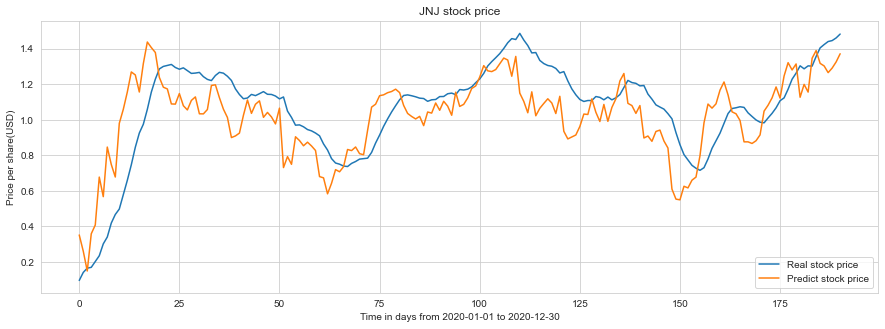

Train Score: 0.97 RMSE
Test Score: 3.99 RMSE
MAE: 0.1566921429046494 and MSE: 0.03710964890741337 and MAPE: 42.71344021053962
[*********************100%***********************]  1 of 1 completed
X shape: (947, 60, 1) 
y shape: (947,)
X shape: (192, 60, 1) 
y shape: (192,)
X shape: (191, 60, 1) 
y shape: (191,)

Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
activation        |selu              |?                 
recurrent_dropout |0.10168           |?                 
num_units         |8                 |?                 
learning_rate     |8.3313e-07        |?                 

Epoch 1/100
24/24 [==============================] - 3s 33ms/step - loss: 0.9291 - mean_absolute_error: 0.9038 - val_loss: 1.5139 - val_mean_absolute_error: 1.2204
Epoch 2/100
24/24 [==============================] - 0s 20ms/step - loss: 0.9223 - mean_absolute_error: 0.9020 - val_loss: 1.5129 - val_mean_absolute_error: 1.2200
Epoch 3/100
24/24 [============================

Epoch 42/100
24/24 [==============================] - 0s 21ms/step - loss: 0.9161 - mean_absolute_error: 0.8971 - val_loss: 1.4744 - val_mean_absolute_error: 1.2042
Epoch 43/100
24/24 [==============================] - 1s 21ms/step - loss: 0.9244 - mean_absolute_error: 0.9013 - val_loss: 1.4735 - val_mean_absolute_error: 1.2038
Epoch 44/100
24/24 [==============================] - 0s 20ms/step - loss: 0.9074 - mean_absolute_error: 0.8915 - val_loss: 1.4725 - val_mean_absolute_error: 1.2034
Epoch 45/100
24/24 [==============================] - 0s 21ms/step - loss: 0.8631 - mean_absolute_error: 0.8703 - val_loss: 1.4716 - val_mean_absolute_error: 1.2030
Epoch 46/100
24/24 [==============================] - 1s 22ms/step - loss: 0.9461 - mean_absolute_error: 0.9125 - val_loss: 1.4706 - val_mean_absolute_error: 1.2026
Epoch 47/100
24/24 [==============================] - 0s 20ms/step - loss: 0.8785 - mean_absolute_error: 0.8791 - val_loss: 1.4697 - val_mean_absolute_error: 1.2022
Epoch 48/1

Epoch 92/100
24/24 [==============================] - 0s 20ms/step - loss: 0.9043 - mean_absolute_error: 0.8885 - val_loss: 1.4271 - val_mean_absolute_error: 1.1845
Epoch 93/100
24/24 [==============================] - 1s 21ms/step - loss: 0.8666 - mean_absolute_error: 0.8677 - val_loss: 1.4262 - val_mean_absolute_error: 1.1841
Epoch 94/100
24/24 [==============================] - 0s 20ms/step - loss: 0.8674 - mean_absolute_error: 0.8717 - val_loss: 1.4252 - val_mean_absolute_error: 1.1837
Epoch 95/100
24/24 [==============================] - 0s 21ms/step - loss: 0.8769 - mean_absolute_error: 0.8775 - val_loss: 1.4243 - val_mean_absolute_error: 1.1833
Epoch 96/100
24/24 [==============================] - 1s 25ms/step - loss: 0.8955 - mean_absolute_error: 0.8864 - val_loss: 1.4234 - val_mean_absolute_error: 1.1829
Epoch 97/100
24/24 [==============================] - 1s 27ms/step - loss: 0.8809 - mean_absolute_error: 0.8743 - val_loss: 1.4224 - val_mean_absolute_error: 1.1826
Epoch 98/1

Epoch 39/100
24/24 [==============================] - 1s 24ms/step - loss: 0.0012 - mean_absolute_error: 0.0263 - val_loss: 0.0031 - val_mean_absolute_error: 0.0419
Epoch 40/100
24/24 [==============================] - 1s 23ms/step - loss: 0.0013 - mean_absolute_error: 0.0279 - val_loss: 0.0031 - val_mean_absolute_error: 0.0417
Epoch 41/100
24/24 [==============================] - 1s 23ms/step - loss: 0.0013 - mean_absolute_error: 0.0271 - val_loss: 0.0031 - val_mean_absolute_error: 0.0415
Epoch 42/100
24/24 [==============================] - 1s 23ms/step - loss: 0.0012 - mean_absolute_error: 0.0262 - val_loss: 0.0033 - val_mean_absolute_error: 0.0437
Epoch 43/100
24/24 [==============================] - 1s 24ms/step - loss: 0.0013 - mean_absolute_error: 0.0272 - val_loss: 0.0031 - val_mean_absolute_error: 0.0414
Epoch 44/100
24/24 [==============================] - 1s 24ms/step - loss: 0.0014 - mean_absolute_error: 0.0278 - val_loss: 0.0031 - val_mean_absolute_error: 0.0414
Epoch 45/1

Epoch 40/100
24/24 [==============================] - 1s 31ms/step - loss: 0.2711 - mean_absolute_error: 0.4655 - val_loss: 0.4775 - val_mean_absolute_error: 0.6797
Epoch 41/100
24/24 [==============================] - 1s 24ms/step - loss: 0.2693 - mean_absolute_error: 0.4630 - val_loss: 0.4732 - val_mean_absolute_error: 0.6766
Epoch 42/100
24/24 [==============================] - 1s 27ms/step - loss: 0.2756 - mean_absolute_error: 0.4688 - val_loss: 0.4690 - val_mean_absolute_error: 0.6735
Epoch 43/100
24/24 [==============================] - 1s 30ms/step - loss: 0.2689 - mean_absolute_error: 0.4627 - val_loss: 0.4647 - val_mean_absolute_error: 0.6704
Epoch 44/100
24/24 [==============================] - 1s 25ms/step - loss: 0.2561 - mean_absolute_error: 0.4517 - val_loss: 0.4605 - val_mean_absolute_error: 0.6672
Epoch 45/100
24/24 [==============================] - 1s 31ms/step - loss: 0.2562 - mean_absolute_error: 0.4496 - val_loss: 0.4562 - val_mean_absolute_error: 0.6641
Epoch 46/1

Epoch 90/100
24/24 [==============================] - 1s 30ms/step - loss: 0.1503 - mean_absolute_error: 0.3364 - val_loss: 0.2637 - val_mean_absolute_error: 0.5007
Epoch 91/100
24/24 [==============================] - 1s 23ms/step - loss: 0.1525 - mean_absolute_error: 0.3395 - val_loss: 0.2595 - val_mean_absolute_error: 0.4965
Epoch 92/100
24/24 [==============================] - 1s 23ms/step - loss: 0.1394 - mean_absolute_error: 0.3210 - val_loss: 0.2553 - val_mean_absolute_error: 0.4923
Epoch 93/100
24/24 [==============================] - 1s 25ms/step - loss: 0.1378 - mean_absolute_error: 0.3179 - val_loss: 0.2511 - val_mean_absolute_error: 0.4880
Epoch 94/100
24/24 [==============================] - 1s 25ms/step - loss: 0.1415 - mean_absolute_error: 0.3254 - val_loss: 0.2469 - val_mean_absolute_error: 0.4838
Epoch 95/100
24/24 [==============================] - 1s 23ms/step - loss: 0.1382 - mean_absolute_error: 0.3236 - val_loss: 0.2427 - val_mean_absolute_error: 0.4794
Epoch 96/1

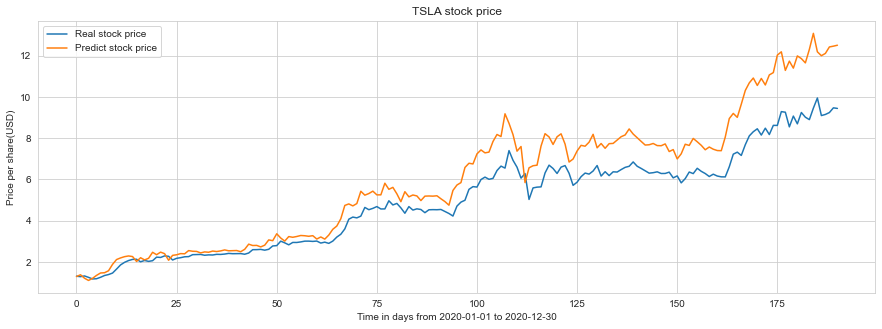

Train Score: 1.96 RMSE
Test Score: 69.90 RMSE
MAE: 1.0698270217807655 and MSE: 1.9239750281875558 and MAPE: 96.16192021037011


In [102]:
# example
for company in companies:
    close_data, train_data, val_data, test_data = data_load_and_split(
        company, start, end)
    train_scaled = scaler.fit_transform(train_data)
    train_supervised = supervised(train_scaled)
    X_train, y_train = split_and_reshape(train_supervised)

    # create validation data
    val_scaled = scaler.fit_transform(val_data)
    val_supervised = supervised(val_scaled)
    X_val, y_val = split_and_reshape(val_supervised)

    # create test data
    test_scaled = scaler.transform(test_data)  # transform not fit_transform
    test_supervised = supervised(test_scaled)
    X_test, y_test = split_and_reshape(test_supervised)

    bayesian_opt_tuner = BayesianOptimization(
        build,
        objective="val_loss",
        max_trials=3,
        executions_per_trial=1,
        directory=os.path.normpath('C:/keras_tuning'),
        project_name='kerastuner_bayesian_poc',
        overwrite=True)
    n_epochs = 100
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    bayesian_opt_tuner.search(X_train, y_train, epochs=n_epochs,
                              validation_data=(X_val, y_val),
                              validation_split=0.2, verbose=1,
                              callbacks=[stop_early])


    bayes_opt_model_best_model = bayesian_opt_tuner.get_best_models(num_models=1)
    model = bayes_opt_model_best_model[0]

    plt.figure(figsize=(15, 5))
    plt.plot(model.predict(X_test), label='Predict stock price')
    plt.plot(y_test, label='Real stock price')
    plt.title(company + ' stock price')
    plt.xlabel('Time in days from 2020-01-01 to 2020-12-30')
    plt.ylabel('Price per share(USD)')
    plt.legend()
    plt.show()

    evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test)
    mse = mean_squared_error(model.predict(X_test), y_test)
    mae = mean_absolute_error(model.predict(X_test), y_test)
    mape = mean_absolute_percentage_error(model.predict(X_test), y_test)
    print('MAE: {} and MSE: {} and MAPE: {}' .format(mae, mse, mape))

## Attention-Based LSTM

In [ ]:
data_load_and_train_test_split(company, start, end)


In [ ]:
data_load_and_train_test_split(company, start, end)
print(f'{train.head()}\n{test.head()}')

In [ ]:
trend_params, att_train = detrend(train)
trend_params, att_test = detrend(test, trend_params)


In [ ]:

scaler = MinMaxScaler(feature_range = (0,1))

In [ ]:
att_train = att_train.to_frame(name='Close')
att_test = att_test.to_frame(name='Close')


In [ ]:
norm_train, norm_test = normalise(scaler, att_train, att_test)

In [ ]:
train_supervised = supervised(norm_train)
X_train, y_train = split_and_reshape(train_supervised)

In [ ]:
input_train = Input(shape=(X_train.shape[1], X_train.shape[2]))
# output_train = Input(shape=(y_train.shape[1], 1))

In [ ]:
from keras.utils.vis_utils import plot_model, model_to_dot
num_units = 128
n_hidden = 128
timesteps = 60
encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(
    n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
    return_state=True, return_sequences=True)(input_train)

encoder_last_h = BatchNormalization(momentum=0.6)(encoder_last_h) 

encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c) 

decoder_input = RepeatVector(1)(encoder_last_h)

decoder_stack_h = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2,
               return_state=False, return_sequences=True)(
    decoder_input, initial_state=[encoder_last_h, encoder_last_c])

attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
attention = Activation('softmax')(attention)

context = dot([attention, encoder_stack_h], axes=[2,1])
context = BatchNormalization(momentum=0.6)(context)

decoder_combined_context = concatenate([context, decoder_stack_h])

out = TimeDistributed(Dense(timesteps))(decoder_combined_context)



In [ ]:
model = Model(inputs=input_train, outputs=out)
opt = Adam(lr=0.01, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
epc = 100
es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
history = model.fit(X_train, y_train, validation_split=0.2, 
                    epochs=epc, verbose=1, callbacks=[es], 
                    batch_size=100)
train_mae = history.history['mae']
valid_mae = history.history['val_mae']